# Preparations

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from copy import deepcopy
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn import svm
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
test_data = pd.read_csv('test.csv')
train_data = pd.read_csv('train.csv')
labels = train_data["purchase"]

## Utility Functions

In [3]:
#input: <np.arr> feature: a feature, <str> feature_name: a feature name, <list> values_range:
#output: <void> Displays stats of feature that helps to determine how to fill na's.
def feature_stats_display (feature, feature_name, values_range = None, lable_relation_box_plot=True):

    #Print stats.
    print("amount of missing data:", feature.isnull().sum(), "\nmedian:", feature.median(), "\nmean:", feature.mean(), "\nmode:", feature.mode()[0],
        "\nmin:", feature.min(), "\nmax:" ,feature.max(), "\namount of min values:", np.count_nonzero(feature == feature.min()),
        "\namount of max values:", np.count_nonzero(feature == feature.max()), "\nskew:", feature.skew())
    
    #plot histogram
    plt.title("histogram of " + feature_name) 
    if (values_range):
        plt.hist(feature, values_range)
    else:
        plt.hist(feature)
    plt.show()
    plt.cla()
    
    #Box plot and label relation plot
    if lable_relation_box_plot:
        #boxplot
        plt.title('box plot')
        feature.plot(kind='box')
        g= plt.figure(2)
        g.show()
        plt.cla()

        #relation to lables
        plt.scatter(labels, feature)
        plt.title('relation to label')
        plt.xlabel('labels')
        plt.ylabel(feature_name)
        plt.show()

#input: <np.arr> feature, <np.arr> lables, <list> values_range: a range of optional outcasts boundries
#output: <int> best_boundry - the best boundry, <int> max_corr - the maximum correaltaion hat the boundry resulted with. 
def find_best_outcast_boundry(feature, labels, values_range):
    max_corr = 0
    best_boundry = 0
    
    for i in values_range:
        temp_corr = feature[feature < i].corr(labels)
        if(temp_corr > max_corr):
            max_corr = temp_corr
            best_boundry = i
    
    return(best_boundry, max_corr)

#input: <df> data, <np.arr> feature,  <str> feature_name: a feature name
#output: The given feature is splitted into different cloumn according to each unique value (using onehotencoding).
def ohe_encoding(data, feature, feature_name):
    count_distinc_values = len(feature.unique()) + 1 #+1 is beacuse im going to use it for range
    onehotencoder = OneHotEncoder()
    #Reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object .
    X = onehotencoder.fit_transform(feature.values.reshape(-1,1)).toarray()

    #To add this back into the original dataframe 
    dfOneHot = pd.DataFrame(X, columns = [feature_name +"_" + str(int(i)) for i in range(1,count_distinc_values)]) 
    data = pd.concat([data, dfOneHot], axis=1)
    return data

#input: <np.arr> feature: a feature
#output: Returns the edited feature after removing outliers accrding to IQR algorithm (and according to cappin or replacing with nan method).
def remove_outlier_IQR(feature,treament = 'cap', factor=1.5):
    Q1=feature.quantile(0.25)
    Q3=feature.quantile(0.75)
    IQR=Q3-Q1
    floor = Q1- (factor *IQR)
    ceil = Q3 + (factor * IQR)
    print("floor value:",floor,"ceil value:" ,ceil)
    if treament == 'remove':
        count_old_nan = feature.isna().sum()
        feature[(feature <= floor) | (feature >= ceil)] = np.NaN
        print("skew after removing IQR:", feature.skew())
        print("amount of removed values:", (feature.isna().sum() - count_old_nan))
    elif treament == 'cap':
        count =(feature[(feature <= floor) | (feature >= ceil)]).shape[0]
        feature = feature.clip(floor, ceil)
        print("skew after capping IQR:", feature.skew())
        print("amount of capped values:", count)
    

    return feature

#input: <np.arr> feature: a feature, <str> feature_name: a feature name
#output: <np.arr> Feature after log transformation, also prints the skew before and after log transformation.
def log_transformation_affection_on_skew(feature):
    
    feature = feature.map(lambda i: np.log(i) if i > 0 else i) 
    print("skew after log transformation:", feature.skew())
    return feature

"""
#This is an early version that I decided not to use

#input: <sklearn.model> a spesific model, <pd.df> x- data, <np.array> y- lables
#output: <void> plots feature's importacne.
def feature_importance(model, x,y):
     feature_names = list(X_train)

     model.fit(x, y)
     importances = model.feature_importances_
     sorted_indices = np.argsort(importances)[::-1]
     fig = plt.figure(figsize = (12, 5))
     plt.title('Feature Importance')
     plt.bar(feature_names, importances[sorted_indices], align='center')
     plt.xticks(rotation=45) 
     plt.tight_layout()
     plt.show()
"""


#input: <np.arr> true lables of train data, <np.arr> predicted lables of train data, <np.arr> prediction probabilities of lables of train data,
        # <np.arr> true lables of validation data, <np.arr> predicted lables of validation data, <np.arr> prediction probabilities of lables of validation data
#output: <void> Prints a report on the given model predictions vs true lables.
def print_model_score_report(y_train, y_train_pred, y_train_pred_proba, y_validation, y_validation_pred, y_validation_pred_proba):

    print("train report:\n",metrics.classification_report(y_train, y_train_pred))
    print("train AUC score is:", roc_auc_score(y_train,y_train_pred_proba[:, 1]))

    print("\nvalidation report:\n", metrics.classification_report(y_Validation, y_validation_pred))
    print("validation AUC score is:",roc_auc_score(y_Validation,y_validation_pred_proba[:, 1]))

#input: <pd.df> x: features, <np.arr> y: lables: a feature name, <int> np: how much feature to select:
#output: <pd.d> returns masking of features that should stay in the data

def forward_selection(x, y, np):
  sfs = SequentialFeatureSelector(LinearRegression(),
          n_features_to_select=np,
          direction = 'forward',
          cv= 3,
          scoring = 'roc_auc')

  sfs.fit(x, y)
  sfs.n_features_to_select_
  masking_for_features = sfs.get_support()
  return masking_for_features

#input: <sklearn.model> a spesific model,<list> importances - list of importances, <pd.df> x- data, <np.array> y- lables
#output: <void> plots feature's importacne.
def feature_importance(model,importances, x,y):
     feature_names = list(X_train)
     feature_names = np.array(feature_names)
     
     sorted_indices = np.argsort(importances)
     sorted_importances =  importances[sorted_indices[::-1]]
 
     sorted_feature_names = feature_names[sorted_indices[::-1]]
     
     #sorted_indices = np.argsort(importances)[::-1]
     fig = plt.figure(figsize = (12, 5))
     plt.title('Feature Importance')
     plt.bar(sorted_feature_names ,  sorted_importances , align='center')
     #plt.bar(feature_names[sorted_indices], importances[sorted_indices], align='center')
     plt.xticks(rotation=45) 
     plt.tight_layout()
     plt.show()
     

#input: <skleran.model> model
#output: <void> plot k fold cross validation roc auc curve
def roc_cross_validation(model):
    cv = StratifiedKFold(n_splits=6)
    classifier =model
    i=0
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for train_index, test_index in cv.split(og_x, og_y):
        
        X_train, X_test = (og_x.T[train_index]).T, (og_x.T[test_index]).T
        y_train, y_test = og_y[train_index], og_y[test_index]
        classifier.fit(X_train, y_train)
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_test,
            y_test,
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        i=i+1
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")
    plt.show()
    return mean_fpr, mean_tpr, mean_auc


def pca_dim_reduction(X, x_test, p):
    """
    Returns arrays of principal components explaining (100*p)% of the variance, one for train and one for test.
    X: 2d numpy array of data I want to apply PCA on. 
    p: float in the range (0,1]. The proportion of variance explained by components
    """
    X = normalize_mean(X)
    
    pca = PCA(n_components=(p), svd_solver='full')
    pca.fit(X)
    X_pca = pca.transform(X)
    x_test_pca = pca.transform(x_test)
    return X_pca, x_test_pca

#input: <pd.df> data
#output: <pd.df> data and plot k fold cross validation roc auc curve
#Remove means before pca.
def normalize_mean(data):
  data = data - data.mean()
  return data

# Data Exploration

In this section I treat each column separately, for each column I determine and track the outliers (if there are outliers at all), and adjust them to the rest of the feature values. I also fill the Nan's according to the rest of the values. In addition, I apply all the changes that were made on the train set also on the test set.

## Num of Admin Pages

I used IQR method to remove outliers. Than decided to fill the nulls with the mean (mean without outliers, so they will not disrupt the value).
I have used the histogram to visualize the distribution, the boxplot to identify if there is a substential amount of outliers, and the corellation to label graph to see if there's any special relation to the label.

amount of missing data: 605 
median: 1.0 
mean: 2.3219566538383636 
mode: 0.0 
min: 0.0 
max: 27.0 
amount of min values: 4618 
amount of max values: 1 
skew: 1.9552442658774265


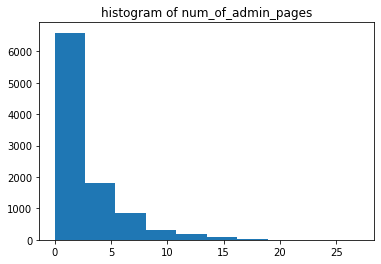

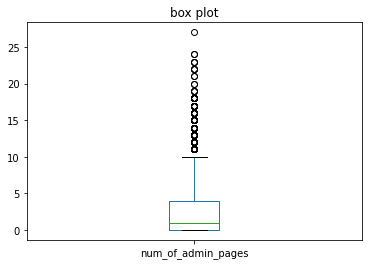

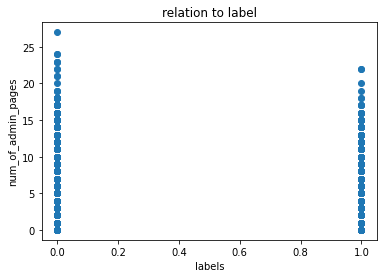

skew after log transformation: 0.572043346825234
amount of missing data: 605 
median: 0.6931471805599453 
mean: 0.797768068043688 
mode: 0.0 
min: 0.0 
max: 3.332204510175204 
amount of min values: 4618 
amount of max values: 1 
skew: 0.572043346825234


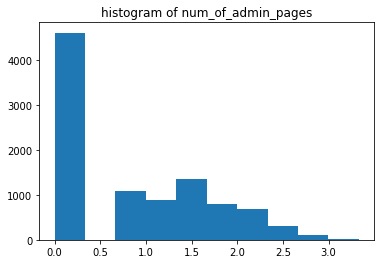

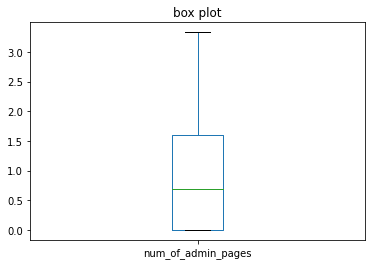

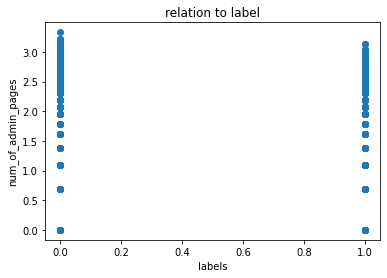

floor value: -2.4141568686511503 ceil value: 4.023594781085251
skew after capping IQR: 0.572043346825234
amount of capped values: 0
skew after log transformation: 0.5389772020948896


In [4]:
#Displaying stats to decide how to fill na's in num_of_admin_pages.
num_of_admin_pages = train_data["num_of_admin_pages"]
feature_stats_display(num_of_admin_pages, "num_of_admin_pages")

#Log transforamtion improves the skew but its ruining the data since there are a lot of zeors in it, and its defined int log function that 0's will not be logged transformed.
#Augment BounceRates by 1, so I can do a log transforamtion.
train_data["num_of_admin_pages"] = num_of_admin_pages.add(1)
num_of_admin_pages = train_data["num_of_admin_pages"]
train_data["num_of_admin_pages"] = log_transformation_affection_on_skew(num_of_admin_pages)
num_of_admin_pages = train_data["num_of_admin_pages"]

#Now the skew is much better, displat stats after changements.
feature_stats_display(num_of_admin_pages, "num_of_admin_pages")

#We try to improve the skew eve nore with IQR method.
remove_outlier_IQR(deepcopy(num_of_admin_pages))
#It's not effective, so evantually I decide not to use it.

#Filling Nans with mean since median is very affected by 0, and anyway there is not much difference between the mean and median
num_of_admin_pages.fillna(num_of_admin_pages.mean(), inplace=True)

#Do same changements for test data
num_of_admin_test = test_data["num_of_admin_pages"]
test_data["num_of_admin_pages"] = num_of_admin_test.add(1)
num_of_admin_test = test_data["num_of_admin_pages"]
test_data["num_of_admin_pages"] = log_transformation_affection_on_skew(num_of_admin_test)
num_of_admin_test = test_data["num_of_admin_pages"]
num_of_admin_test.fillna(num_of_admin_test.mean(), inplace = True)

## Num of Info Pages

There are a lot of sagnificant outliers. I tried using a function which uses the corelation to the label to find out best coundary for our outliers. it seems to give us a good boundary (one that make sense according to distrebution. than I fill nulls (and outliers) with the mean.
I used the histogram to visualize the distribution, the boxplot to identify if there is a substential amount of outliers(there is), and the corellation to label graph to see if therews any special relation to the label.

amount of missing data: 687 
median: 0.0 
mean: 0.5026552287581699 
mode: 0.0 
min: 0.0 
max: 24.0 
amount of min values: 7693 
amount of max values: 1 
skew: 4.140015421732166


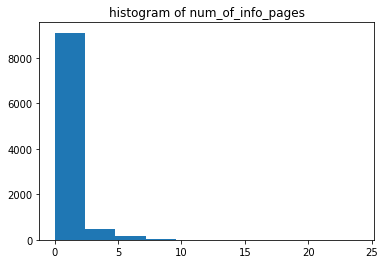

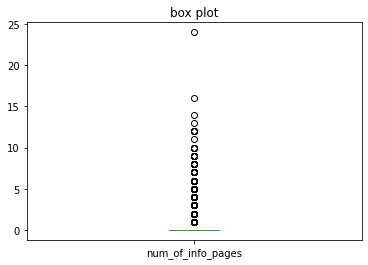

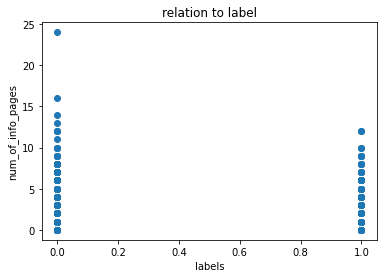

 info before: 750
 info after: 0


In [5]:
num_of_info_pages = train_data["num_of_info_pages"]
num_of_info_pages.replace("minutes", 0)
feature_stats_display(num_of_info_pages, "num_of_info_pages")

#find best boundry outcast for num_of_info_pages, since there are a lot of data that seems outcast
info_num_boundry, max_corr_info_num = find_best_outcast_boundry(num_of_info_pages, labels, [0, 1, 2, 3,4,5,6,7,8,9])
num_of_info_pages[num_of_info_pages > info_num_boundry] = None #remove outcasts

#filling Nans
print(" info before:", num_of_info_pages.isnull().sum())
num_of_info_pages.fillna(num_of_info_pages.mean(), inplace=True)
print(" info after:", num_of_info_pages.isnull().sum())

#do same changments for test data
num_of_info_test = test_data["num_of_info_pages"]
num_of_info_test.replace("minutes", 0)
num_of_info_test[num_of_info_test> info_num_boundry]= None
num_of_info_test.fillna(num_of_info_test.mean(), inplace=True)

## Num of Product Pages

I used std method to remove outliers, beacuse after log transformatuon the data looks normal distributed. Also, I decided to fill the nulls with the mean (mean without outliers, so they will not disrupt the value).
I used the histogram to visualize the distribution, the boxplot to identify if there is a substential amount of outliers, and the corellation to label graph to see if there's any special relation to the label.

amount of missing data: 403 
median: 18.0 
mean: 31.870186581976974 
mode: 1.0 
min: 0.0 
max: 705.0 
amount of min values: 31 
amount of max values: 1 
skew: 4.3709308822715816


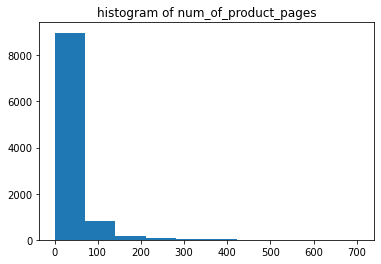

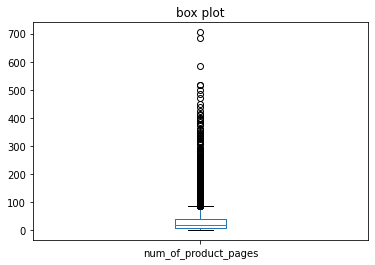

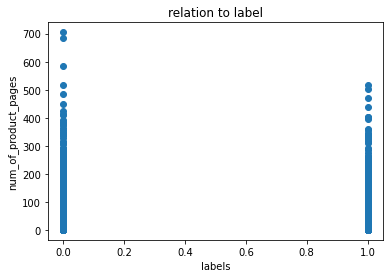

skew after log transformation: -0.2989127951117749
amount of missing data: 403 
median: 2.8903717578961645 
mean: 2.7708078387368826 
mode: 0.0 
min: 0.0 
max: 6.558197802812269 
amount of min values: 530 
amount of max values: 1 
skew: -0.2989127951117749


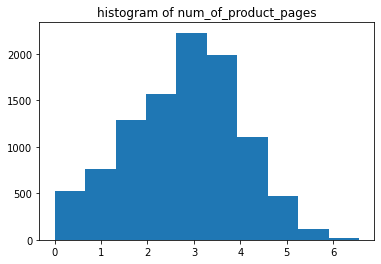

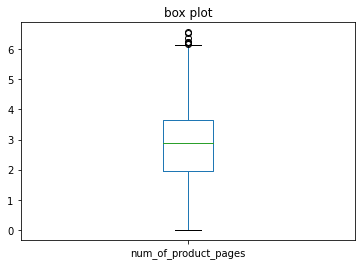

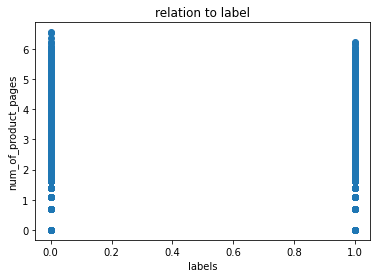

skew after log transformation: -0.30689944501781125


In [6]:
num_of_product_pages = train_data["num_of_product_pages"]
feature_stats_display(num_of_product_pages, "num_of_product_pages")

#the skew is really bad, I have to remove outliers, there are only 31 0's in the data so it would seem that log transformation will fit here
train_data["num_of_product_pages"] = log_transformation_affection_on_skew(num_of_product_pages)
feature_stats_display(num_of_product_pages, "num_of_product_pages")

#now the distribution is almost normall so I fillna's using normal distrbution rules
num_of_product_pages_mean, num_of_product_pages_std = num_of_product_pages.mean(), num_of_product_pages.std()
# identify outliers
cut_off = num_of_product_pages_std * 3
lower, upper = num_of_product_pages_mean - cut_off, num_of_product_pages_mean + cut_off
num_of_product_pages[num_of_product_pages > upper] = None
num_of_product_pages[num_of_product_pages < lower] = None
num_of_product_pages.fillna(num_of_product_pages_mean, inplace=True)


#do same changments for test data
num_of_product_test = test_data["num_of_product_pages"]
test_data["num_of_product_pages"] = log_transformation_affection_on_skew(num_of_product_test)
num_of_product_test.fillna(num_of_product_test.mean(), inplace=True)
num_of_product_test_mean, num_of_product_test_std = num_of_product_test.mean(), num_of_product_test.std()
cut_off = num_of_product_test_std * 3
lower, upper = num_of_product_test_mean - cut_off, num_of_product_test_mean + cut_off
num_of_product_test[num_of_product_test > upper] = None
num_of_product_test[num_of_product_test < lower] = None
num_of_product_test.fillna(num_of_product_test_mean, inplace=True)


## Admin Page Duration

I have used IQR method to remove outliers. Than I decided to fill the nulls with the mean (mean without outliers, so they will not disrupt the value).
I used the histogram to visualize the distribution, the boxplot to identify if there is a substential amount of outliers, and the corellation to label graph to see if therews any special relation to the label.

amount of missing data: 0 
median: 0.6931471805599453 
mean: 0.7977680680436879 
mode: 0.0 
min: 0.0 
max: 3.332204510175204 
amount of min values: 4618 
amount of max values: 1 
skew: 0.5893027770559067


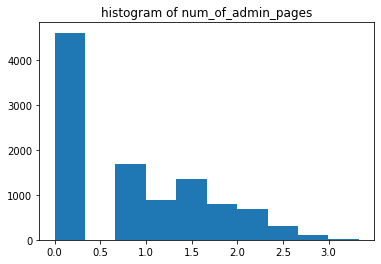

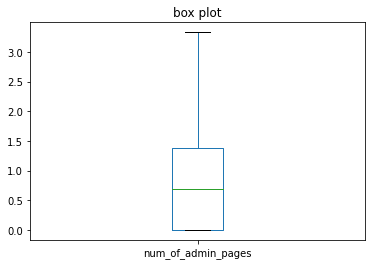

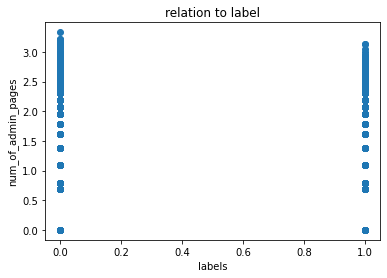

skew after log transformation: 0.7224835990345514
floor value: -2.0794415416798357 ceil value: 3.465735902799726
skew after capping IQR: 0.5893027770559067
amount of capped values: 0
amount of missing data: 0 
median: 0.6931471805599453 
mean: 0.7977680680436879 
mode: 0.0 
min: 0.0 
max: 3.332204510175204 
amount of min values: 4618 
amount of max values: 1 
skew: 0.5893027770559067


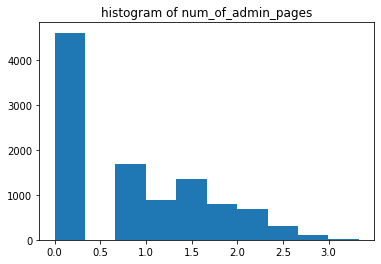

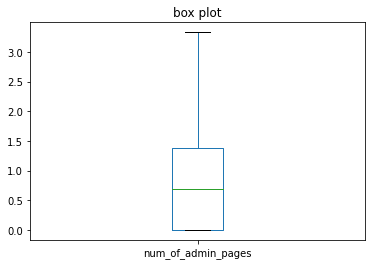

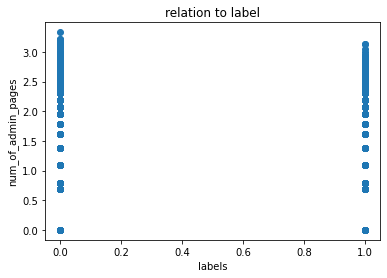

floor value: -150.89999999999998 ceil value: 251.49999999999997
skew after capping IQR: 1.2276806854685713
amount of capped values: 175


In [7]:
#displaying stats to decide how to fill na's in num_of_admin_pages
admin_page_duration = train_data["admin_page_duration"]
feature_stats_display(num_of_admin_pages, "num_of_admin_pages")

log_transformation_affection_on_skew(deepcopy(num_of_admin_pages))
#log transforamtion improves the skew, but it splits the data to several groups so I preffer IQR

#therefore I decide to use IQR
train_data["num_of_admin_pages"]  = remove_outlier_IQR(num_of_admin_pages)
feature_stats_display(num_of_admin_pages, "num_of_admin_pages")
#now the skew is much better, tho still a bit high

#fill the blanks in admin
admin_page_duration.fillna(admin_page_duration.mean(), inplace=True)

#do same changments for test data
admin_page_duration_test = test_data["admin_page_duration"]
test_data["admin_page_duration"]  = remove_outlier_IQR(admin_page_duration_test)
admin_page_duration_test.fillna(admin_page_duration_test.mean(), inplace=True)

## Info Page Duration

 I used the histogram to visualize the distribution, the boxplot to identify if there is a substantial amount of outliers, and the correlation to label graph to see if there's any special relation to the label.

There are very high values outliers to remove. I used the boxplot and histogram to get a sense of the right border for removal. I used log transformation to reduce the skew, but it is still high because of the quantity of the zero values. still I decided to leave the values, because I cannot cap or remove so many zeros and we don't want to ruin the relativity of the rest of the data. I decided to fill the nulls with the mean(mean without 0, so they will not disrupt the value).

amount of missing data: 317 
median: 0.0 
mean: 34.32381284503198 
mode: 0.0 
min: 0.0 
max: 2549.375 
amount of min values: 8176 
amount of max values: 1 
skew: 7.791512376451665


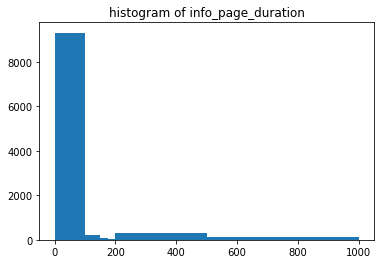

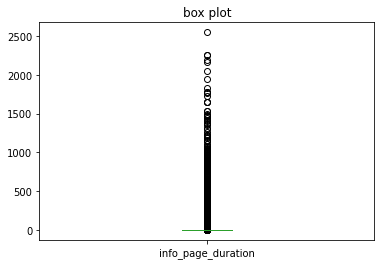

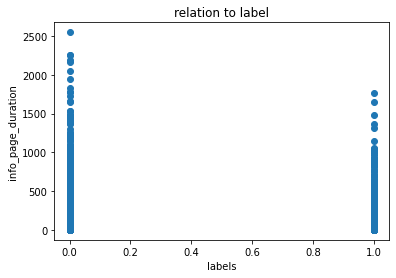

skew after log transformation: 1.9196384627920762
amount of missing data: 317 
median: 0.0 
mean: 0.8431287540852369 
mode: 0.0 
min: 0.0 
max: 7.843995686163913 
amount of min values: 8176 
amount of max values: 1 
skew: 1.9196384627920762


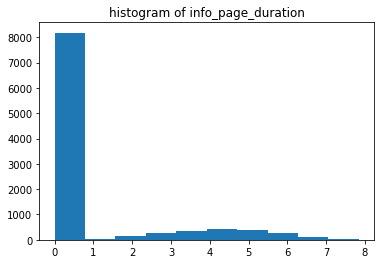

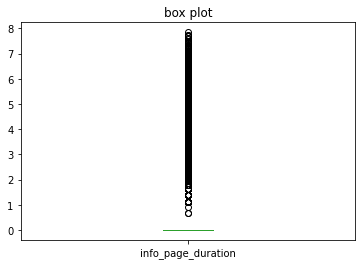

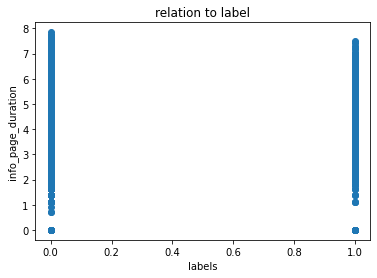

skew after log transformation: 1.9172508886038986


In [8]:
#Arranging the feature to a float format,
train_data["info_page_duration"]= train_data["info_page_duration"].str.replace('minutes', '')
train_data["info_page_duration"] = train_data["info_page_duration"].astype(float)

info_duration = train_data["info_page_duration"]

#Display stats.
feature_stats_display(info_duration, "info_page_duration", [0,100,150, 175, 200, 500,1000])

#Reduce outliers using log transformation,since there a lot of zero values, I augment all the values by one.
train_data["info_page_duration"] = info_duration.add(1)
info_duration = train_data["info_page_duration"]
train_data["info_page_duration"] = log_transformation_affection_on_skew(info_duration)
info_duration = train_data["info_page_duration"]

#I tried to use IQR but it leaves only zero values. the zero's makes a lot of skew, but I leave them beacuse I can't cap so many values.

#Display stats after changements.
feature_stats_display(info_duration, "info_page_duration")

#Fill the blanks in info.
mean = info_duration[info_duration > 0].mean()
info_duration.fillna(mean, inplace=True)

#Do same changments for test.
test_data["info_page_duration"]= test_data["info_page_duration"].str.replace('minutes', '')
test_data["info_page_duration"] = test_data["info_page_duration"].astype(float)
info_duration_test = test_data["info_page_duration"]
test_data["info_page_duration"] = info_duration_test.add(1)
info_duration_test = test_data["info_page_duration"]
test_data["info_page_duration"] = log_transformation_affection_on_skew(info_duration_test)
info_duration_test = test_data["info_page_duration"]
mean_test = info_duration_test[info_duration_test > 0].mean()
info_duration_test.fillna(mean_test, inplace=True)

## product page duration

There are very high values oultiers to remove. I use the boxplot and histogram to get a sense of the right border for removal. Than I have found the precentile according to the value I have located, and removed the outliers by it. I decided to fill the nulls with the mean (mean without outliers, so it will not disrupt the value).
I have used the histogram to visualize the distribution, the boxplot to identify if there is a substential amount of outliers and the corellation to label graph to see if there's any special relation to the label.

max 63973.52223
amount of missing data: 621 
median: 598.44166665 
mean: 1197.518515991716 
mode: 0.0 
min: 0.0 
max: 63973.52223 
amount of min values: 594 
amount of max values: 1 
skew: 7.840251085757437


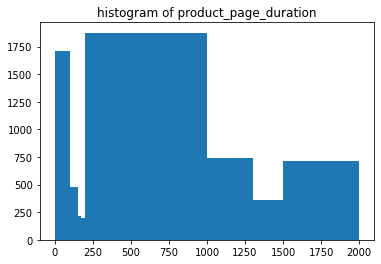

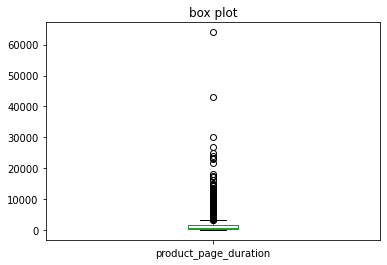

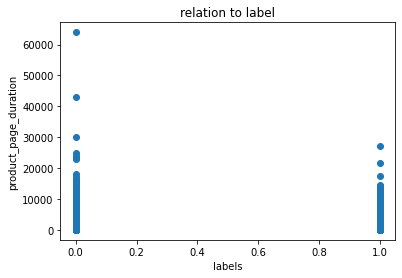

In [9]:
#Arranging the feature to a float format.
train_data["product_page_duration"]= train_data["product_page_duration"].str.replace('minutes', '')
train_data["product_page_duration"] = train_data["product_page_duration"].astype(float)

test_data["product_page_duration"]= test_data["product_page_duration"].str.replace('minutes', '')
test_data["product_page_duration"] = test_data["product_page_duration"].astype(float)

product_duration = train_data["product_page_duration"]
product_duration_test = test_data["product_page_duration"]
print("max", max(product_duration))
feature_stats_display(product_duration, "product_page_duration", [0,100,150, 175, 200, 500,1000, 1300, 1500,2000])


product_duration[product_duration >product_duration.quantile(.95)] = None
product_duration_test[product_duration_test >product_duration_test.quantile(.95)]= None

#Fill the blanks in product
product_duration.fillna(product_duration.mean(), inplace=True)
product_duration_test.fillna(product_duration_test.mean(), inplace=True)

## total duration

As for now, this is the only feature I have decided to drop, because it gives us no new information over the other duration features.

## Bounce Rates

The skew of the values is a bit high, and therefore I decided to reduce it using log transformation (thus, removing outliers). to use the log transformation I have to augment the values by 1, since the value 0 is very common and I cannot perform a log on 0. Then I use IQR - which reduces the skew just a little bit . Also, I fill the nan's with the median, since anyway there is no a lot of null's and I want to keep the variance as it is.

amount of missing data: 22 
median: 0.002968037 
mean: 0.021853844369417615 
mode: 0.0 
min: 0.0 
max: 0.2 
amount of min values: 4722 
amount of max values: 584 
skew: 2.982551831335165


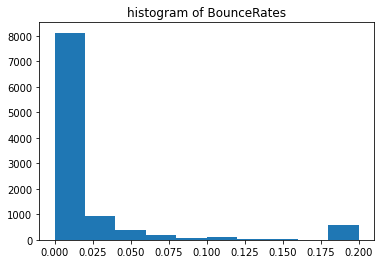

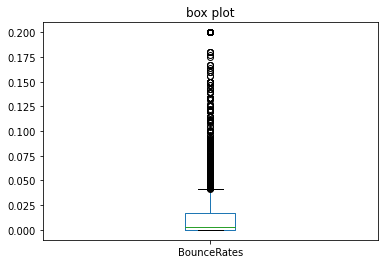

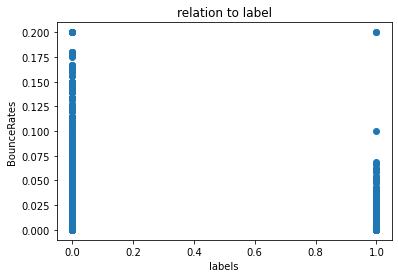

correlation between BounceRates and the lables: -0.15068277635605326
skew after log transformation: 2.911089816129181
floor value: -0.024793953418619077 ceil value: 0.04132325569769846
skew after capping IQR: 1.207648253538138
amount of capped values: 1288
floor value: -0.024793953418619077 ceil value: 0.04132325569769846
skew after removing IQR: 1.6780447754944954
amount of removed values: 1288
floor value: -0.024793953418619077 ceil value: 0.04132325569769846
skew after capping IQR: 1.207648253538138
amount of capped values: 1288
amount of missing data: 22 
median: 0.0029636410742156236 
mean: 0.010656215841966807 
mode: 0.0 
min: 0.0 
max: 0.04132325569769846 
amount of min values: 4722 
amount of max values: 1288 
skew: 1.207648253538138


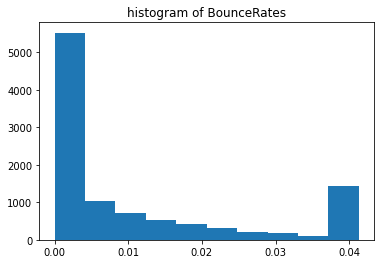

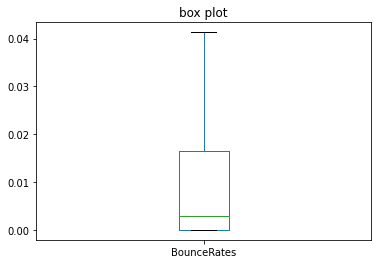

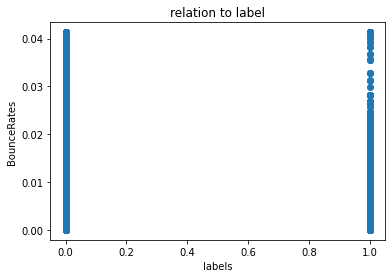

skew after log transformation: 2.721716327735961
floor value: -0.02778528214308441 ceil value: 0.04630880357180735
skew after capping IQR: 1.2009181595764153
amount of capped values: 226


In [10]:
#Displaying stats to decide how to fill na's in bounce rates.
BounceRates = train_data["BounceRates"]
feature_stats_display(BounceRates, "BounceRates")

#Check correlation between the BounceRates and lables.
print("correlation between BounceRates and the lables:", BounceRates.corr(labels))

#Correlation is very low, and box plot isn't stable, so I abseloutly need to remove outliers.
#Log transformation really changes the skew, but since there are a lot of zeros it also alters the data.
#Augment BounceRates by 1, so I can do a log transforamtion
train_data["BounceRates"] = BounceRates.add(1)
BounceRates = train_data["BounceRates"]
train_data["BounceRates"] = log_transformation_affection_on_skew(BounceRates)
BounceRates = train_data["BounceRates"]

remove_outlier_IQR(deepcopy(BounceRates))
remove_outlier_IQR(deepcopy(BounceRates), treament = 'remove')

#capping is better than removing so I use it
train_data["BounceRates"] = remove_outlier_IQR(BounceRates)
BounceRates = train_data["BounceRates"]

#display stats again after changments
feature_stats_display(BounceRates, "BounceRates")

#the are very few missing values and therefore we'll use median to fill them
#fill nans in train
BounceRates.fillna(BounceRates.median(), inplace=True)

#do same changments for test data
BounceRates_test = test_data["BounceRates"]
test_data["BounceRates"] = BounceRates_test.add(1)
BounceRates_test = test_data["BounceRates"]
test_data["BounceRates"] = log_transformation_affection_on_skew(BounceRates_test)
test_data["BounceRates"] = remove_outlier_IQR(BounceRates_test)
BounceRates_test = test_data["BounceRates"]
test_data.fillna(BounceRates_test.median(), inplace=True)


## Exit Rates

The skew of the values is very high, which means that there are outliers, I can also physically see it by looking at the plot above of the values distribution. To avoid having so many outliers I use a log transformation, which improves the skew, and also keeps the relativity between the values. After using the log transformation the skew is 0.06 which is very good, and means that the distribution is very similar to a normal distribution, therefore I decide to treat the feature as normally distributed. Moreover, I fill the Nan's with the mean, since the feature is treated as normally distributed (anyway there are only 26 Nan's which isn't much). 

amount of missing data: 26 
median: 0.02516129 
mean: 0.0428591114353774 
mode: 0.2 
min: 0.0 
max: 0.2 
amount of min values: 64 
amount of max values: 593 
skew: 2.1622290301544256


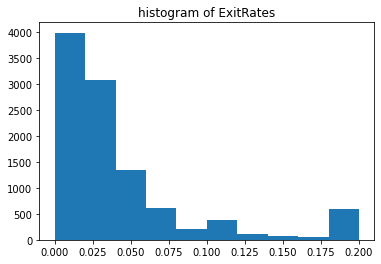

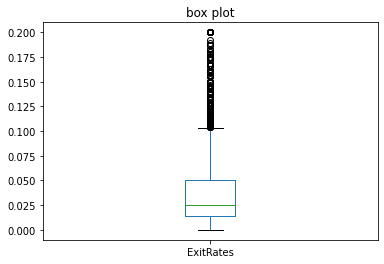

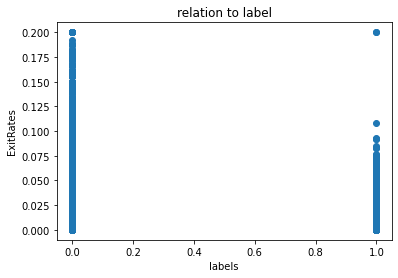

skew after log transformation: 0.0665491955087067
amount of missing data: 26 
median: -3.660421490582754 
mean: -3.6118612335564646 
mode: -1.6094379124341003 
min: -8.647341740883562 
max: 0.0 
amount of min values: 1 
amount of max values: 64 
skew: 0.0665491955087067


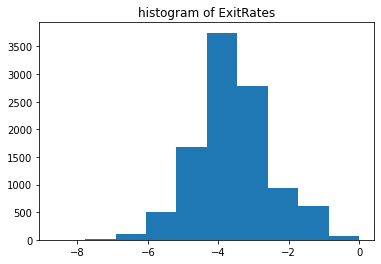

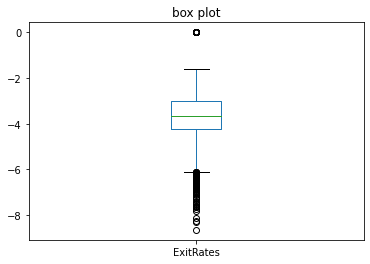

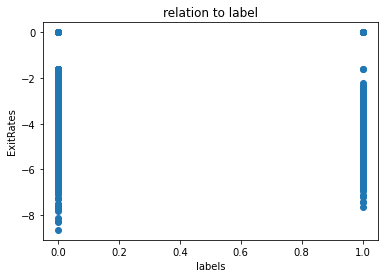

amount of missing data: 0 
median: -3.6458620728197193 
mean: -3.6225243384641117 
mode: -1.6094379124341003 
min: -6.751101163936807 
max: -1.6094379124341003 
amount of min values: 1 
amount of max values: 593 
skew: -0.01415964211467168


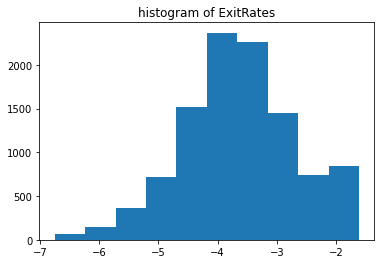

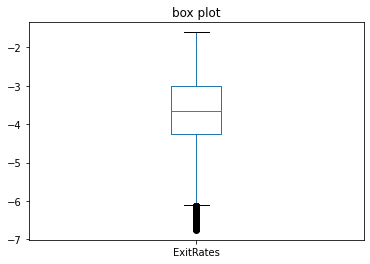

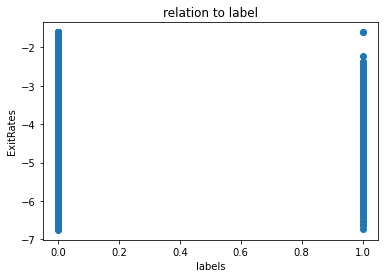

skew after log transformation: 0.09741091355665611


In [11]:
#Displaying stats to decide how to fill na's in exit reates.
ExitRates = train_data["ExitRates"]
feature_stats_display(ExitRates, "ExitRates")


#Log transformation really changes the skew so I use it.
train_data["ExitRates"] = log_transformation_affection_on_skew(deepcopy(ExitRates))
ExitRates = train_data["ExitRates"]

#Display stats again after changments.
feature_stats_display(ExitRates, "ExitRates")
#log transformation heleped a lot, 0.06 is a great skew! since it look like a "normal" distribution.

#To outcast I will assume its an normal distribution and use the std rule.
#At the beggining there were just 26 nan's which is not a lot anyway, so I'll change them with the rest od nan's.

ExitRates_mean, ExitRates_std = ExitRates.mean(), ExitRates.std()
#Identify outliers.
cut_off = ExitRates_std * 3
lower, upper = ExitRates_mean - cut_off, ExitRates_mean + cut_off
ExitRates[ExitRates > upper] = None
ExitRates[ExitRates < lower] = None
ExitRates.fillna(ExitRates_mean, inplace=True)

#Display stats again after changments.
feature_stats_display(ExitRates, "ExitRates")

#Make same changments in test data.
ExitRates_tests = test_data["ExitRates"]
test_data["ExitRates"] = log_transformation_affection_on_skew(deepcopy(ExitRates_tests))
ExitRates_tests = test_data["ExitRates"]
ExitRates_mean, ExitRates_std = ExitRates_tests.mean(), ExitRates_tests.std()
cut_off = ExitRates_std * 3
lower, upper = ExitRates_mean - cut_off, ExitRates_mean + cut_off
ExitRates_tests[ExitRates_tests > upper] = None
ExitRates_tests[ExitRates_tests < lower] = None
ExitRates_tests.fillna(ExitRates_mean, inplace=True)


## Page Values

Firstly, the skew was very high and therefore I used a log transformation to reduce its skew (I kept in mind that there a lot of zero's values, and because of that - decided to augment each value by 1 before applying log transformation). Afterwards I tried to reduce the feature even more by applying IQR, but I gave up on doing that because it wasn't efficient because of the many zeros values. Finally, by checking the correlation of the outliers to the labels, I figured that they are very correlated, and therefore I preferred to keep the outliers values rather than capping/removing them. I fill the nans with the mode and median value, which is 0, and anyway there are very few null's.

amount of missing data: 27 
median: 0.0 
mean: 5.900387156143322 
mode: 0.0 
min: 0.0 
max: 361.7637419 
amount of min values: 8138 
amount of max values: 1 
skew: 6.532473593434832


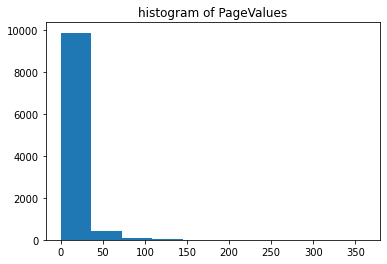

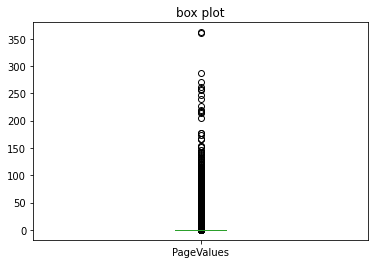

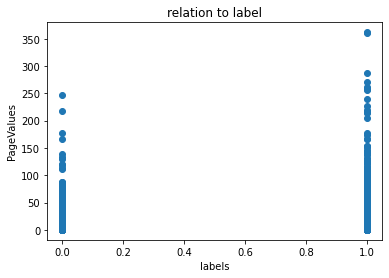

skew after log transformation: 1.8072121664045193
floor value: 0.0 ceil value: 0.0
skew after capping IQR: 0
amount of capped values: 10452
floor value: 0.0 ceil value: 0.0
skew after removing IQR: nan
amount of removed values: 10452
amount of missing data: 27 
median: 0.0 
mean: 0.6242725407005181 
mode: 0.0 
min: 0.0 
max: 5.8937517736105205 
amount of min values: 8138 
amount of max values: 1 
skew: 1.8072121664045193


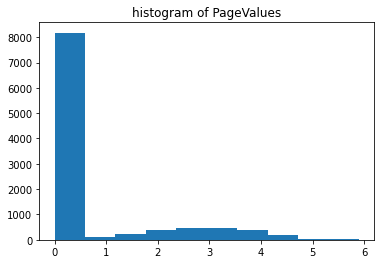

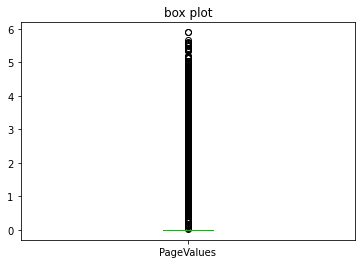

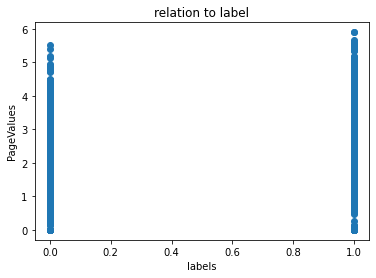

values above 4: 310
correlation between PageValues zero values and the lables: 0.962029982796756
correlation between PageValues above 4 values and the lables: 0.7967741935483871
correlation between BounceRates and the lables: 0.3132789104971318
skew after log transformation: 1.806881447779859


In [12]:
#Displaying stats to decide how to fill na's in num_of_admin_pages.
PageValues = train_data["PageValues"]
feature_stats_display(PageValues, "PageValues")

#To prevent the log transformation from altering with the 5000 values of 0's (since I cannot do a log on 0), I add 1 to all of the values.
#I Augmented PageValues by 1, so I could do a log transforamtion.
train_data["PageValues"] = PageValues.add(1)
PageValues = train_data["PageValues"]
train_data["PageValues"] = log_transformation_affection_on_skew(PageValues)
PageValues = train_data["PageValues"]

#I try to reduce skew with IQR
remove_outlier_IQR(deepcopy(PageValues))
remove_outlier_IQR(deepcopy(PageValues), treament = 'remove')
#This dosent help, since zero value is appearing to much for the IQR method to be efficient.

#Display stats after changements.
feature_stats_display(PageValues, "PageValues")

#Check how much values are above 4.
print("values above 4:", PageValues[PageValues > 4].shape[0])

#Lets check the corrleation of zero values to the lables.
page_only_0 = PageValues[PageValues == 0]
page_above_4 = PageValues[PageValues > 4]
corr_page_0 = page_only_0[(page_only_0 == 0) & (labels == 0)].count() / (page_only_0.count())
corr_page_above_4 = page_above_4[(page_above_4 >= 4) & (labels == 1)].count() / (page_above_4.count())
print("correlation between PageValues zero values and the lables:", corr_page_0)
print("correlation between PageValues above 4 values and the lables:", corr_page_above_4)
page_without_0 = PageValues[PageValues > 0]
print("correlation between BounceRates and the lables:", page_without_0.corr(labels))
#The correlation of the zero values, and the values above 4 are very correlated to the lables.
#In contrast, the rest of the values are less corellated to the lables. This means that our outliers are important, and I decide to leave them as they are.

#Mode is significanly zero and also the median is zero, therefore I use the mode to fill the na's (anyway there are few zero's).
PageValues.fillna(PageValues.median(), inplace=True)

#Make same changements in test data.
PageValuestest = test_data["PageValues"]
test_data["PageValues"] = PageValuestest.add(1)
PageValues_test = test_data["PageValues"]
test_data["PageValues"] = log_transformation_affection_on_skew(PageValues_test)

PageValues_test.fillna(PageValues_test.median(), inplace=True)

## Device

This a categorical feature, since the mode is 2 - I've decided to fill all the values with this value. I tried to prove that maybe this feature is not important , by checking it's correlation values-labels differences, just to discover that there are significantly different correlations and therefore I cannot drop the feature for now.

amount of missing data: 323 
median: 2.0 
mean: 2.122981488775108 
mode: 2.0 
min: 1.0 
max: 8.0 
amount of min values: 2130 
amount of max values: 64 
skew: 2.0407842593810193


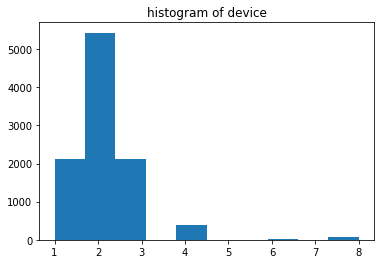

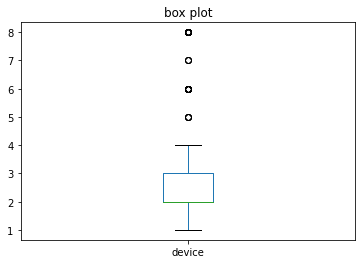

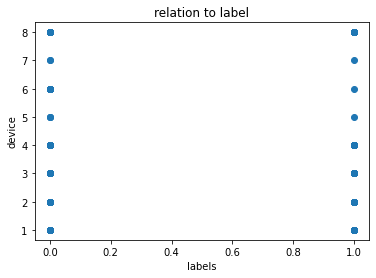

correalation between the different devices kind and 1 lables : 0.153 2: 0.175 3: 0.102 4: 0.188


In [13]:
#Displaying stats to decide how to fill na's in device.
device = train_data["device"]
feature_stats_display(device, "device")

#I assume that this feature is not very signifficant to the prediction, lets check that assumption.
#Thus, by checking if the most common devices are more or less correlated in the same way to the lables:
percantage_bought_1 = device[(device == 1) & (labels == 1)].count() / device[(device == 1)].count()
percantage_bought_2 = device[(device == 2) & (labels == 1)].count() / device[(device == 2)].count()
percantage_bought_3 = device[(device == 3) & (labels == 1)].count() / device[(device == 3)].count()
percantage_bought_4 = device[(device == 4) & (labels == 1)].count() / device[(device == 4)].count()
print("correalation between the different devices kind and 1 lables :", round(percantage_bought_1,3), "2:", 
    round(percantage_bought_2, 3), "3:", round(percantage_bought_3, 3), "4:", round(percantage_bought_4,3))
#I can see that the assumption was wrong since the value 3 isn't simillar to other devices.

#Since mode is 2 and it's a categorical feature, I pick the mode as the value to fill the NaN's.
device.fillna(device.mode(), inplace=True)

#It's a categorical feature so I use ine hot encoding to split into several different.
train_data = ohe_encoding(train_data, device, "device")

#Do same changement in test data.
device_test = test_data["device"]
test_data = ohe_encoding(test_data, device_test, "device")
device_test.fillna(device_test.mode(), inplace=True)


##  Internet Browser

This is a categorical feature, therefore I do not try remove outliers. For commutable reasons, I changed  the values of the feature to numerical values. I also decide to fill the NaN's with the mode value and use one hot encoding (since it's a categorical feature).

amount of missing data: 563 
median: 3.0 
mean: 2.569080274304155 
mode: 3 
min: 1 
max: 4 
amount of min values: 1952 
amount of max values: 588 
skew: -0.8384322785756104


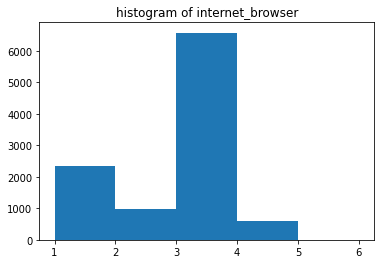

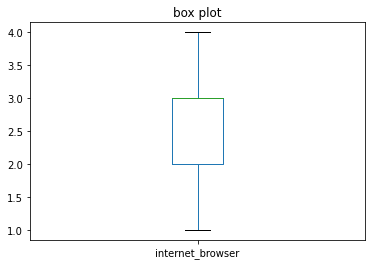

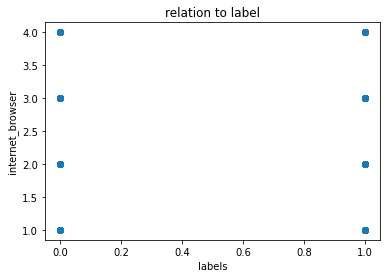

In [14]:
#Logicly I assume that it dosent matter which is the version of th browser, what matters (if at all), is the kind of 
#therefore I edit the values to: 'safari' 'browser' 'chrome' 'edge'.
train_data["internet_browser"] = train_data["internet_browser"].str.split('_').str[:-1].str.join('_')
train_data["internet_browser"] = train_data["internet_browser"].str.replace("_", "")
train_data["internet_browser"] = train_data["internet_browser"].str.replace('\d+', '')

internet_browser = train_data["internet_browser"]

#I change the values to be numerical.
internet_browser[internet_browser == 'safari'] = 1
internet_browser[internet_browser == 'browser'] = 2
internet_browser[internet_browser == 'chrome'] = 3
internet_browser[internet_browser == 'edge'] = 4

#Displaying stats to decide how to fill na's in internet_browser.
feature_stats_display(internet_browser, "internet_browser", range(1,7))

#Not suprisingly, most of users use chrome (3). There is a lot of missing data, since mode is chrome - I fill the na's with it.
internet_browser.fillna(internet_browser.mode()[0], inplace=True)

#It's a categorical feature so I use hot encoding to split the feature into several different features.
train_data = ohe_encoding(train_data, internet_browser, "internet_browser")

#Do same changments on test data.
test_data["internet_browser"] = test_data["internet_browser"].str.split('_').str[:-1].str.join('_')
test_data["internet_browser"] = test_data["internet_browser"].str.replace("_", "")
test_data["internet_browser"] = test_data["internet_browser"].str.replace('\d+', '')
internet_browser_test = test_data["internet_browser"]
internet_browser_test[internet_browser_test == 'safari'] = 1
internet_browser_test[internet_browser_test == 'browser'] = 2
internet_browser_test[internet_browser_test == 'chrome'] = 3
internet_browser_test[internet_browser_test == 'edge'] = 4
internet_browser_test.fillna(internet_browser_test.mode()[0], inplace=True)
test_data = ohe_encoding(test_data, internet_browser_test, "internet_browser")

## Region

This is a categorical feature so I decide to use one hot encoding and fill the NaN with the mode value. 

amount of missing data: 19 
median: 3.0 
mean: 3.155640535372849 
mode: 1.0 
min: 1.0 
max: 9.0 
amount of min values: 4056 
amount of max values: 431 
skew: 0.9726578700536725


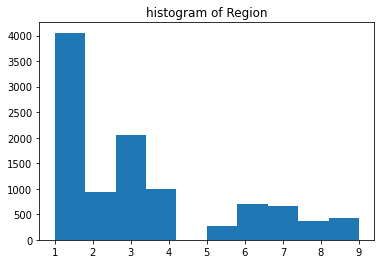

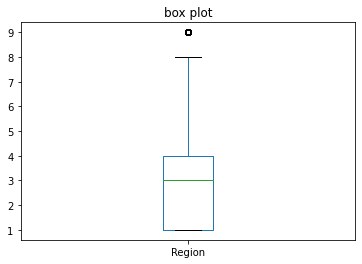

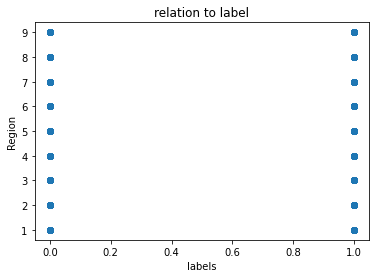

In [15]:
#Displaying stats to decide how to fill na's in Region.
Region = train_data["Region"]
feature_stats_display(Region, "Region")

#Only 19 values are missing, so I just replace them with the mode (since its categorical, mean and median dosen't help).
Region.fillna(Region.mode()[0], inplace=True)

#its a categorical feature so I use ine hot encoding to split into several different
train_data = ohe_encoding(train_data, Region, "Region")


#do same changments on test data
Region_test = test_data["Region"]
Region_test.fillna(Region_test.mode()[0], inplace=True)
test_data = ohe_encoding(test_data, Region_test, "Region")


## User Type

This is a categorical feature, there are very few 'other's in the data, so I decided to treat those values as Nan. Also, I change the names of the values to numeric values,  I fill the NaN with the mode value and use one hot encoding method.

amount of missing data: 95 
median: 1.0 
mean: 0.8624807395993837 
mode: 1 
min: 0 
max: 1 
amount of min values: 1428 
amount of max values: 8956 
skew: -2.10533498068853


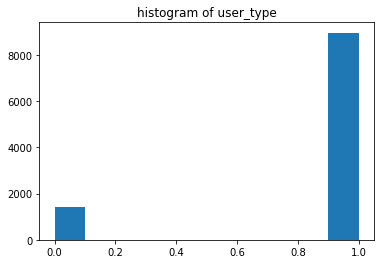

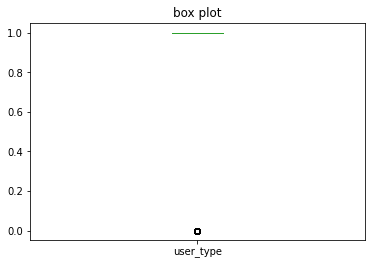

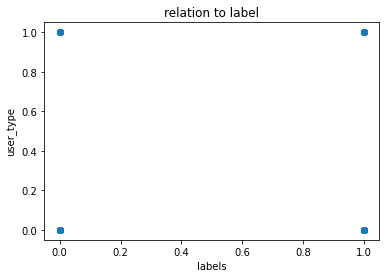

In [16]:
user_type = train_data["user_type"]

#Change the data to a numerical data.
#There are 59 "other" values, which I'll be treated as unknown.
user_type[user_type == 'New_Visitor'] = 0
user_type[user_type == 'Returning_Visitor'] = 1
user_type[user_type == 'Other'] = np.NaN


#Displaying stats to decide how to fill na's in user_type
feature_stats_display(user_type, "user_type")

#There are 97 None, which is not a lot. Since there are much more Returning_Visitor than new ones, I'll just assume that
#Nans are returnig visitors.
user_type.fillna(user_type.mode()[0], inplace=True)

#Do same changments on test data
user_type_test = test_data["user_type"]

user_type_test[user_type_test == 'New_Visitor'] = 0
user_type_test[user_type_test == 'Returning_Visitor'] = 1
user_type_test[user_type_test == 'Other'] = np.NaN

user_type_test.fillna(user_type_test.mode()[0], inplace=True)



## Month

This is a categorical feature, there are very few 'other's in the data, so I decided to treat those values as Nan. Also, I change the names of the values to numeric values,  I fill the NaN with the mode value and use one hot encoding method.

amount of missing data: 0 
median: 7.0 
mean: 7.635079683175875 
mode: 5 
min: 2 
max: 12 
amount of min values: 163 
amount of max values: 1450 
skew: -0.047423485807373815


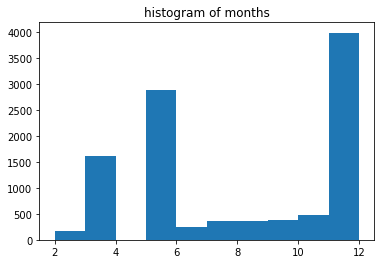

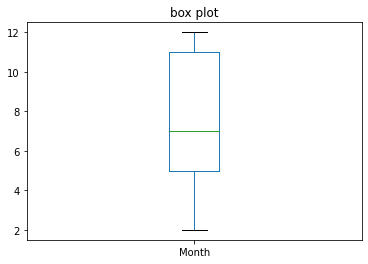

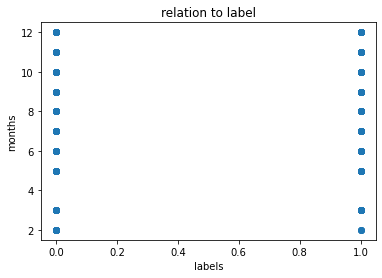

In [17]:
Month = train_data["Month"]

#Change to numeric values
con_dict ={month: index for index, month in enumerate(calendar.month_abbr) if month}
Month.replace("June","Jun", inplace=True)
Month.replace(con_dict, inplace=True)

#Only 25 NaN. since it's a categoric variable, I will use the mode for replacment. there are no outcasts.
Month.fillna(int(Month.mode()), inplace=True)
Month = Month.astype(int)

feature_stats_display (Month, "months")

#its a categorical feature so I use one hot encoding to split into several different categories.
train_data = ohe_encoding(train_data, Month, "Month")

#Do same changements for test
Month_test = test_data["Month"]
Month_test.replace("June","Jun", inplace=True)
Month_test.replace(con_dict, inplace=True)
Month_test.fillna(int(Month_test.mode()), inplace=True)
Month_test = Month_test.astype(int)
test_data = ohe_encoding(test_data, Month_test, "Month")

## Weekend

This is a categorical feature, therefore I fill NaN with the mode, change the values to numerical values and use one hot encoding.

weekend_buy 419
weekend_not_buy 1996
not_weekend_buy 1197
not_weekend_not_buy 6844
weekend ratio: 0.17349896480331262
week days ratio: 0.14886208183061808
amount of missing data: 23 
median: 0.0 
mean: 0.23096786534047437 
mode: 0.0 
min: 0.0 
max: 1.0 
amount of min values: 8041 
amount of max values: 2415 
skew: 1.2768751627417778


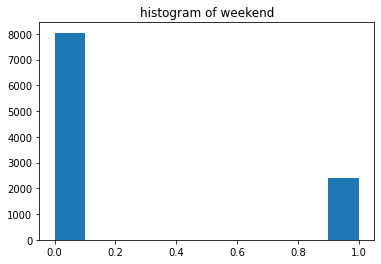

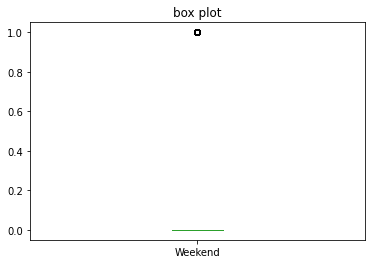

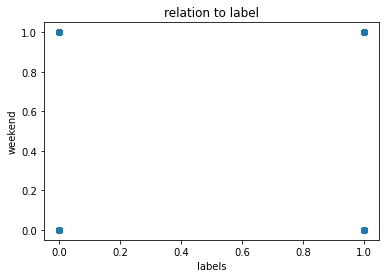

In [18]:
Weekend  = train_data["Weekend"]
Weekend.replace({True:1, False:0}, inplace=True)

weekend_buy = Weekend[(Weekend==1) & (labels==1)].count()
print("weekend_buy", weekend_buy)
weekend_not_buy = Weekend[(Weekend==1) & (labels==0)].count()
print("weekend_not_buy", weekend_not_buy)
not_weekend_buy = Weekend[(Weekend==0) & (labels==1)].count()
print("not_weekend_buy", not_weekend_buy)
not_weekend_not_buy = Weekend[(Weekend==0) & (labels==0)].count()
print("not_weekend_not_buy", not_weekend_not_buy)
weekend_buying_ratio = weekend_buy/(weekend_buy+weekend_not_buy)
print("weekend ratio:",weekend_buying_ratio )
week_days_buying_ratio =  not_weekend_buy/(not_weekend_buy+not_weekend_not_buy)
print("week days ratio:",week_days_buying_ratio)

#Display stats after changments
feature_stats_display (Weekend, "weekend")

#there is an unsignificent amount of nulls. I will fill those with zeros, which are more common.
Weekend.fillna(Weekend.mode()[0], inplace=True)

#Do same changments for test
Weekend_test  = test_data["Weekend"]
Weekend_test.replace({True:1, False:0}, inplace=True)
Weekend_test.fillna(Weekend_test.mode()[0], inplace=True)

## Closeness to Holiday

I do not remove outliers in this data because it's a statistical feature. I fill the the NaN with the mode, again because it's a statistical feature. 

nulls: 496
o lable nulls: 417
median: 0.0
mean 0.061985375137734146
0 values: 8958
amount of missing data: 0 
median: 0.0 
mean: 0.059051436205744816 
mode: 0.0 
min: 0.0 
max: 1.0 
amount of min values: 9454 
amount of max values: 123 
skew: 3.3799060929109306


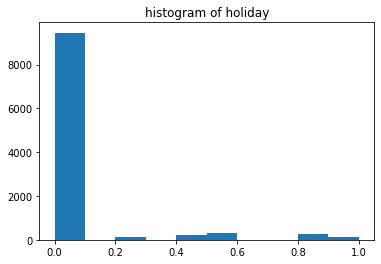

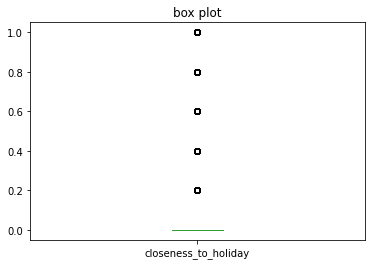

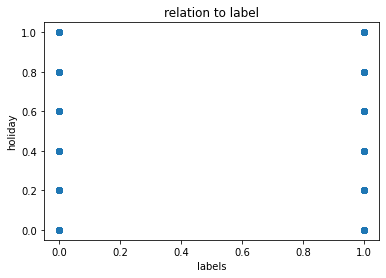

In [19]:
closeness_to_holiday =  train_data["closeness_to_holiday"]

print("nulls:", closeness_to_holiday.isnull().sum())
print("o lable nulls:", closeness_to_holiday[labels==0].isnull().sum())
print("median:", closeness_to_holiday.median())
print("mean", closeness_to_holiday.mean())
print("0 values:", closeness_to_holiday[closeness_to_holiday==0.0].count())

#It seems logical to fill nulls with 0- the mode(by far) and median. 
closeness_to_holiday.fillna(closeness_to_holiday.mode()[0], inplace=True)

#Display stats after changments
feature_stats_display(closeness_to_holiday ,"holiday")

#Do same changments for test
closeness_to_holiday_test =  test_data["closeness_to_holiday"]
closeness_to_holiday_test.fillna(closeness_to_holiday_test.mode()[0], inplace=True)

## A

I figured out that this feature is probably categorical, because it has a weird distribution and a range of values which seems categorical. The only exception is the values which begins with "20_XX" , which seems a bit odd from the rest of the data. I've decided to turn all those values to 20 - in expectation that those values represents categories that are ideally close to the 20 category, or even are sub-categories of 20, and therefore indicates on relative close information. I decided to fill the Nan's with the mode since it's a categorical feature and I don't have much choice, and finally used one hot encoding.

amount of missing data: 706 
median: 2.0 
mean: 4.077891128619666 
mode: 2.0 
min: 1.0 
max: 20.99 
amount of min values: 1944 
amount of max values: 3 
skew: 2.02369553079894


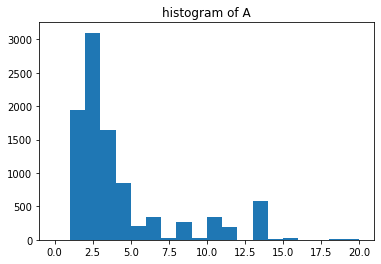

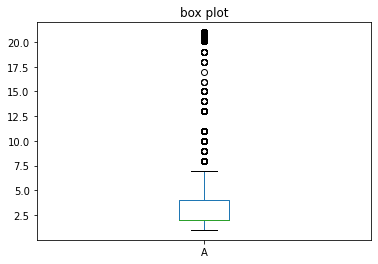

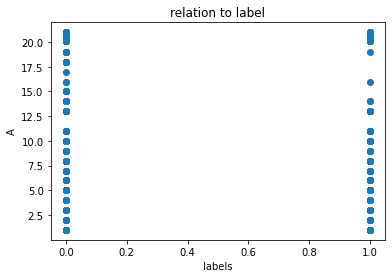

amount of missing data: 706 
median: 2.0 
mean: 4.068556226337869 
mode: 2.0 
min: 1.0 
max: 20.0 
amount of min values: 1944 
amount of max values: 162 
skew: 1.9749192097499695


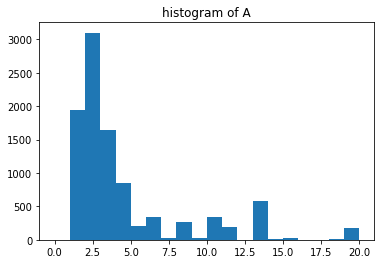

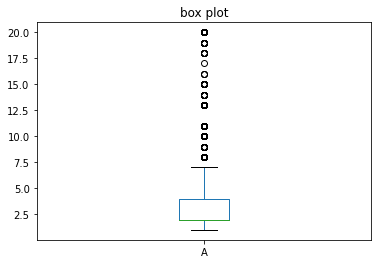

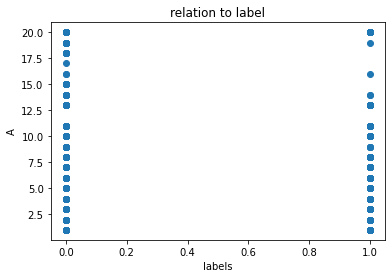

In [20]:
#By looking at the feature it is clear that "c_" is not nesseary and I replace it, the problem is the underscore.
#which appears at the middle of the 20 numbers, Iv'e decided to turn it into a decimal point.

train_data["A"] = train_data["A"].str.replace("c_", "")
train_data["A"] = train_data["A"].str.replace("_", ".")
train_data["A"] = train_data["A"].astype(float)

A = train_data["A"]

#Displaying stats to decide how to fill na's in A
feature_stats_display(A, "A",range(0,21))

#The 20 values are prbablly pretty similiar, so let us put a 20 value instead of them.
A[A>20] = 20

feature_stats_display(A, "A",range(0,21))

#I figuered that this is a categorical feature, so I assing to the nulls the mode value.
A.fillna(A.mode()[0], inplace=True)

#I use one hot encoding to split into several different features.
train_data = ohe_encoding(train_data, A, "A")

#Do same changement in test data
test_data["A"] = test_data["A"].str.replace("c_", "")
test_data["A"] = test_data["A"].str.replace("_", ".")
test_data["A"] = test_data["A"].astype(float)
A_test = test_data["A"]
A_test[(A_test>20) & (21>A_test)] = 20
A_test.fillna(A_test.mode()[0], inplace=True)
test_data = ohe_encoding(test_data, A_test, "A")

## B

From the histogram, I eas able to identify that B is normaly distributed. Therefore, I used std(*3) as a boundary for outliers. Than, I filled it with the mean.

I used the histogram to visualize the distribution, the boxplot to identify if there is a substential amount of outliers, and the corellation to label graph to see if there's any special relation to the label.

amount of missing data: 23 
median: 99.78724862 
mean: 99.76962828180662 
mode: 60.73391891 
min: 60.73391891 
max: 141.7351421 
amount of min values: 1 
amount of max values: 1 
skew: -0.014209731687308658


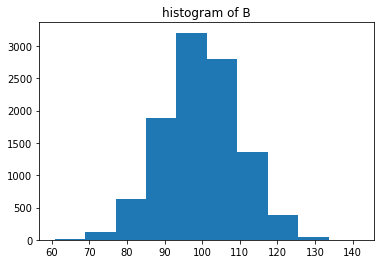

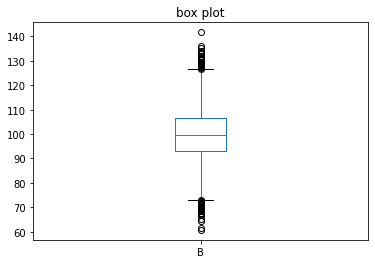

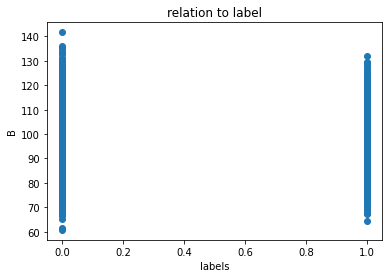

In [21]:
#I can see that b has a normal distribution. therefore, I have removed outliers by std test and filled them with mean.
B = train_data["B"]
feature_stats_display(B, "B")

B_mean, B_std = B.mean(), B.std()

#Identify outliers
cut_off = B_std * 3
lower, upper = B_mean - cut_off, B_mean + cut_off

#Make outliers Nan.
B[B>upper] =None
B[B<lower] = None

# Fill NaNs.
B.fillna(B_mean, inplace=True)

#Do same changement in test data
B_test = test_data["B"]
B_test_mean, B_test_std = B_test.mean(), B_test.std()
cut_off_test = B_test_std * 3
lower_test, upper_test = B_test_mean - cut_off_test, B_test_mean + cut_off_test
B_test[B_test>upper_test] =None
B_test[B_test<lower_test] = None
B_test.fillna(B_test_mean, inplace=True)

## C

I removed the 'log' str, and than I identified that the C feature is devided to two splitable groups. There were very little nulls, so I just considered them as part of the larger group. I had no information about C feature. It seems numeric, but there are a lot of repititive values, which made us suspicious about the values. Therefore, I used the mode of each group to fill outliers and nulls, instead of the usual mean.

amount of missing data: 23 
median: 400.0 
mean: 1568.999234889059 
mode: 200.0 
min: 100.0 
max: 8080.0 
amount of min values: 1731 
amount of max values: 1748 
skew: 1.778460145291229


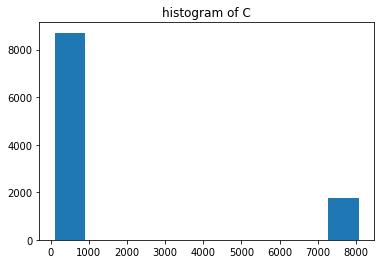

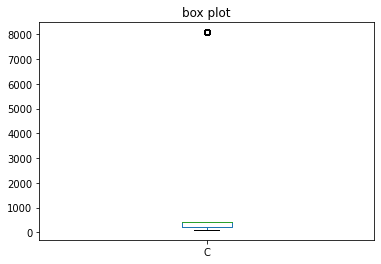

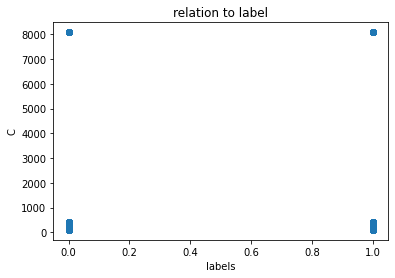

high: 0    8080.0
dtype: float64
low: 0    200.0
dtype: float64
nulls: 23


In [22]:
#Remove str.
train_data['C'] = train_data['C'].str.replace('log', '')
train_data['C'] = train_data['C'].str.replace('_', '')
train_data['C'] = train_data['C'].astype(float)
C = train_data['C']

#Display stats.
feature_stats_display (C, "C")

C_high = C[C>7000]
C_low =C[C<1000]

print("high:",C_high.mode())
print("low:",C_low.mode())
print("nulls:",C.isnull().sum())

#Theres only 23 nulls. so we will fill it in with the mode of the lower range, because his frequency is the highest
C.fillna(int(C_low.mode()), inplace=True)

#Do same changments for test.
test_data['C'] = test_data['C'].str.replace('log', '')
test_data['C'] = test_data['C'].str.replace('_', '')
test_data['C'] = test_data['C'].astype(float)
C_test = test_data['C']
C_low_test = C_test[C_test<1000]
C_test.fillna(int(C_low_test.mode()), inplace=True)

## D

I was able to identify a very strong split in D features in accordance to the labels. D is splitable to two groups - one which  correlates almost perfectly to labels of 1, and the other to 0. Therefore, I found the boundary using the median between the higher group low IQR and the low group high IQR. Than, we transformed D into a new feature -1 for label=1 correlated group, and -1 for the label=0 group, and 0 to the nulls(there's a lot of them).

I used the histogram to visualize the distribution, the box-plot to identify if there is a substantial amount of outliers, and the correlation to label graph to see if there's any special relation to the label.

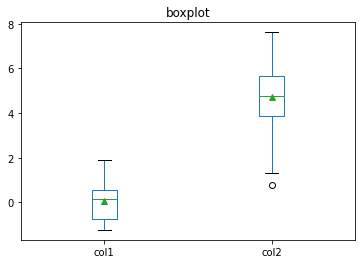

bought higher bound 0.5539466945
didnt buy lower bound 3.848503891


In [23]:
D = train_data["D"]
D_test = test_data["D"]

D_NO =D[labels==0]
D_YES =D[labels==1]

DF = pd.DataFrame({'col1': D_YES, 'col2': D_NO})
ax = DF[['col1', 'col2']].plot(kind='box', title='boxplot', showmeans=True)
plt.show()

q3_Y = D_YES.quantile(0.75)
q1_N = D_NO.quantile(0.25)

print("bought higher bound", q3_Y)
print("didnt buy lower bound", q1_N)
med_val =D[(q3_Y<D)&(D<q1_N)].mean()


#This variable calssifies the data almost perfectly. I will make it into a categorical feature- 1 for the values which are corelated with 
#labels=1, -1 for labels=0, and 0 for nulls. I chose the desicison boundry as the mean of the samples which are both above of the buy 75% and 
#below the 25% of the didnt buy.
D.fillna(0, inplace=True)
train_data.loc[((train_data["D"]< med_val) & (train_data["D"]!=0)), "D"] = 1
train_data.loc[train_data["D"]> med_val, "D"] = -1

#Do same changments for test
D_NO_test =D_test[labels==0]
D_YES_test =D_test[labels==1]
q3_Y_test = D_YES_test.quantile(0.75)
q1_N_test = D_NO_test.quantile(0.25)
med_val_test =D_test[(q3_Y_test<D_test)&(D_test<q1_N_test)].mean()
D_test.fillna(0, inplace=True)
test_data.loc[((test_data["D"]< med_val_test) & (test_data["D"]!=0)), "D"] = 1
test_data.loc[test_data["D"]> med_val_test, "D"] = -1


## Drop Columns

Drop categorial primal columns, I don't need them since I did one hot encoding.

In [24]:
train_data = train_data.drop(['id', 'Month', 'Region', 'device', 'internet_browser'], 1)
test_data = test_data.drop(['id', 'Month', 'Region', 'device', 'internet_browser'], 1)

# Normalization

We&nbsp;normalize&nbsp;all&nbsp;the&nbsp;numeric&nbsp;data,&nbsp;this&nbsp;is&nbsp;very&nbsp;important&nbsp;because&nbsp;the&nbsp;weights&nbsp;of&nbsp;the features are heavily effected by the scale of each feature value. It contributes to business understanding and also in this way the weights don't have a huge difference between them which interrupts the learning process. Thus, by normalizing we prevent the model from giving too much weight for the large scaled features.

In [25]:
numeric_features = ["num_of_admin_pages", "admin_page_duration", "num_of_info_pages", "info_page_duration",
"num_of_product_pages", "product_page_duration", "A", "C", "BounceRates", "ExitRates", "PageValues"]

# Apply normalization technique.
for feature in numeric_features:
    feature_scaled = (train_data[feature] - train_data[feature].min())/ (train_data[feature].max() - train_data[feature].min())
    train_data[feature] = feature_scaled

# Do same changments for test.
numeric_data_test = ["num_of_admin_pages", "admin_page_duration", "num_of_info_pages", "info_page_duration",
"num_of_product_pages", "product_page_duration", "A", "C", "BounceRates", "ExitRates","PageValues"]
for feature in numeric_features:
    feature_scaled = (test_data[feature] - test_data[feature].min())/ (test_data[feature].max() - test_data[feature].min())
    test_data[feature] = feature_scaled

# Dimension Reduction

Dimensionality reduction is very important in order to maintain the model complexity in the right amount following the bias variance tradeoff rules. If there will be too many features, the model complexity will increase. This leads to a lower bias on the train model, but also to higher variance. A very complex model is overfitted on the training set, and it's test MSE will probably increase after an amount of features. A very simple model, on the other hand, may be generic and not overfitted to our train, but it will have a high bias, and will not make good predictions. To sum it up, Dimensionality reduction technics are meant to extract fewer features from the data, while keeping it predictions accurate.

I think that the best way to identify too high dimension is through the difference between the train and test MSE. If there are too many dimensions, the test MSE will stop dropping and even rise, unlike the train MSE that will continue to drop due to overfitting, beacuase of the Bayes variance tradeoff.

In [26]:
#splitting to y_train and x_train
y_train = train_data['purchase']
x_train = train_data.drop('purchase',1)
x_train = x_train.drop("total_duration",1)
x_test = test_data.drop("total_duration",1)
columns = x_train.columns

print("amount of dimensions", x_train.shape[1])

amount of dimensions 67


# Filter

In this section in order to filter features, we present two kind of correaltion verifications:
1. Correlation of numeric features to labels. 
2. Correlation of features to other features.

In [27]:
numeric_data = train_data[["num_of_admin_pages", "admin_page_duration", "num_of_info_pages", "info_page_duration",
"num_of_product_pages", "product_page_duration", "A", "C", "BounceRates", "ExitRates", "PageValues"]]

print("correlation of features to lables:\n\n", numeric_data.corrwith(labels))


correlation of features to lables:

 num_of_admin_pages       0.162514
admin_page_duration      0.095410
num_of_info_pages        0.095724
info_page_duration       0.110606
num_of_product_pages     0.196691
product_page_duration    0.150219
A                       -0.003300
C                        0.016988
BounceRates             -0.180741
ExitRates               -0.235605
PageValues               0.635053
dtype: float64


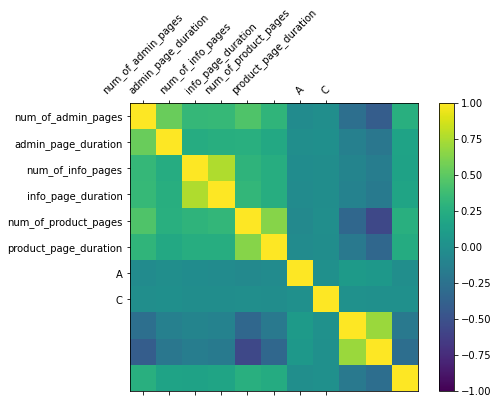

<Figure size 432x288 with 0 Axes>

In [28]:
correlations = numeric_data.corr(method ='pearson')

# Plotting confussion matrix.
num_data = ["num_of_admin_pages", "admin_page_duration", "num_of_info_pages", "info_page_duration",
"num_of_product_pages", "product_page_duration", "A", "C"]
fig = plt.figure()
ax = fig.add_subplot(111)
subplotsize=[8.,8.]
figuresize=[8.,8.]   
left = 0.5*(1.-subplotsize[0]/figuresize[0])
right = 1.-left
bottom = 0.5*(1.-subplotsize[1]/figuresize[1])
top = 1.-bottom
fig.subplots_adjust(left=left,right=right,bottom=bottom,top=top)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,8,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(num_data)
ax.set_yticklabels(num_data)
ax.set_xticklabels(num_data,rotation=45)
plt.show()
plt.savefig('conmat.png')

In [29]:
#Drop all the duration features (beside product- it seems slightly less highky corellated)
#beacause they have very strong correlation to the according num of pages.

x_train = x_train.drop(['admin_page_duration','info_page_duration', 'product_page_duration'], 1)
x_test = x_test.drop(['admin_page_duration','info_page_duration', 'product_page_duration'], 1)

Following the correlations verifications, I decided to drop all the duration features since they seem highly correlated with the "num of pages" features. With that said, the 'product duration' feature seems less correlated to 'product duration', therefore I decided not to drop it.

In [30]:
print("amount of dimensions after reduction", x_train.shape[1])

amount of dimensions after reduction 64


## PCA

In this section I will use business understanding in order to divide the current features to groups, before conducting PCA on each group. I chose using PCA in this way, since it enables us to keep a basic business understanding of the models results.

Data&nbsp;preparations&nbsp;for&nbsp;PCA:

In [31]:
print("list of existung features:\n", columns)
website_data = x_train[['num_of_admin_pages', 'num_of_info_pages', 'num_of_product_pages',
       'BounceRates', 'ExitRates', 'PageValues']]
timing_of_visit_data = x_train[['closeness_to_holiday','Weekend', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10']]
user_details = x_train[['device_1', 'device_2',
       'device_3', 'device_4', 'internet_browser_1', 'internet_browser_2',
       'internet_browser_3', 'internet_browser_4','Region_1', 'Region_2',
        'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8',
       'Region_9', 'user_type']]

unknown_variabalse_data = x_train[['A', 'B', 'C']]
D_collumn = x_train['D']

list of existung features:
 Index(['num_of_admin_pages', 'admin_page_duration', 'num_of_info_pages',
       'info_page_duration', 'num_of_product_pages', 'product_page_duration',
       'BounceRates', 'ExitRates', 'PageValues', 'closeness_to_holiday',
       'user_type', 'Weekend', 'A', 'B', 'C', 'D', 'device_1', 'device_2',
       'device_3', 'device_4', 'device_5', 'device_6', 'device_7', 'device_8',
       'device_9', 'internet_browser_1', 'internet_browser_2',
       'internet_browser_3', 'internet_browser_4', 'Region_1', 'Region_2',
       'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8',
       'Region_9', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'A_1', 'A_2',
       'A_3', 'A_4', 'A_5', 'A_6', 'A_7', 'A_8', 'A_9', 'A_10', 'A_11', 'A_12',
       'A_13', 'A_14', 'A_15', 'A_16', 'A_17', 'A_18', 'A_19'],
      dtype='object')


In [32]:
#Do the same for test data.
print("list of existung features:\n", columns)
website_data_test = x_test[['num_of_admin_pages', 'num_of_info_pages', 'num_of_product_pages',
       'BounceRates', 'ExitRates', 'PageValues']]

timing_of_visit_data_test = x_test[['closeness_to_holiday','Weekend', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10']]

user_details_test = x_test[['device_1', 'device_2',
       'device_3', 'device_4', 'internet_browser_1', 'internet_browser_2',
       'internet_browser_3', 'internet_browser_4','Region_1', 'Region_2',
        'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8',
       'Region_9', 'user_type']]

unknown_variabalse_data_test = x_test[['A', 'B', 'C']]
D_collumn_test = x_test['D']

list of existung features:
 Index(['num_of_admin_pages', 'admin_page_duration', 'num_of_info_pages',
       'info_page_duration', 'num_of_product_pages', 'product_page_duration',
       'BounceRates', 'ExitRates', 'PageValues', 'closeness_to_holiday',
       'user_type', 'Weekend', 'A', 'B', 'C', 'D', 'device_1', 'device_2',
       'device_3', 'device_4', 'device_5', 'device_6', 'device_7', 'device_8',
       'device_9', 'internet_browser_1', 'internet_browser_2',
       'internet_browser_3', 'internet_browser_4', 'Region_1', 'Region_2',
       'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8',
       'Region_9', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'A_1', 'A_2',
       'A_3', 'A_4', 'A_5', 'A_6', 'A_7', 'A_8', 'A_9', 'A_10', 'A_11', 'A_12',
       'A_13', 'A_14', 'A_15', 'A_16', 'A_17', 'A_18', 'A_19'],
      dtype='object')


apply&nbsp;all&nbsp;reductions&nbsp;on&nbsp;data:

In [33]:
#Preform PCA.
p =0.98
website_pca, website_test_pca = pca_dim_reduction(website_data, website_data_test, p)
timing_of_visit_pca, timing_of_visit_test_pca = pca_dim_reduction(timing_of_visit_data, timing_of_visit_data_test, 0.96)
user_details_pca, user_details_test_pca = pca_dim_reduction(user_details, user_details_test, 0.96)
unknown_variabalse_pca, unknown_variabalse_test_pca = pca_dim_reduction(unknown_variabalse_data, unknown_variabalse_data_test, p)

#Print results of PCA.
print("website results:\nnumber of features before PCA:", website_data.shape[1],
    "\nnumber of features after PCA:", website_pca.shape[1])
print("\nduration of visit results:\nnumber of features before PCA:", timing_of_visit_data.shape[1],
    "\nnumber of features after PCA:", timing_of_visit_pca.shape[1])
print("\nuser details results:\nnumber of features before PCA:", user_details.shape[1],
    "\nnumber of features after PCA:", user_details_pca.shape[1])
print("\nunknown variables results:\nnumber of features before PCA:", unknown_variabalse_data.shape[1],
    "\nnumber of features after PCA:", unknown_variabalse_pca.shape[1])

website results:
number of features before PCA: 6 
number of features after PCA: 6

duration of visit results:
number of features before PCA: 12 
number of features after PCA: 9

user details results:
number of features before PCA: 18 
number of features after PCA: 13

unknown variables results:
number of features before PCA: 3 
number of features after PCA: 1


In [34]:
#eventually we decide not to use this code block, therefore its hashtagged.

#hole data pca
#print(x_train.shape)
#x_train = StandardScaler().fit_transform(x_train)
#pca = PCA(n_components = 0.99, svd_solver = 'full')
#X_reduced = pca.fit_transform(x_train)
#print(X_reduced.shape)

#hole forward
#forward_selection(X_reduced, y_train, 0.8)

In [35]:
#Create a new train data frame, after the pca. 
website_pca_data = pd.DataFrame(website_pca, columns = ['PCA_website_1', 'PCA_website_2', 'PCA_website_3', 'PCA_website_4', 'PCA_website_5', 'PCA_website_6'])
timing_pca_data = pd.DataFrame(timing_of_visit_pca, columns = ['PCA_time_1','PCA_time_2', 'PCA_time_3', 'PCA_time_4',
'PCA_time_5', 'PCA_time_6', 'PCA_time_7', 'PCA_time_8', 'PCA_time_9'])

user_pca_data = pd.DataFrame(user_details_pca, columns = ['PCA_user_1','PCA_user_2', 'PCA_user_3', 'PCA_user_4',
'PCA_user_5','PCA_user_6','PCA_user_7','PCA_user_8', 'PCA_user_9', 'PCA_user_10','PCA_user_11','PCA_user_12','PCA_user_13'])

unknown_variabalse_pca_data = pd.DataFrame(unknown_variabalse_pca, columns = ['PCA_1'])

new_train_data = pd.concat([website_pca_data,timing_pca_data, user_pca_data, unknown_variabalse_pca_data, D_collumn], axis=1)

print("amount of dimensions after PCA:", new_train_data.shape[1])

amount of dimensions after PCA: 30


In [36]:
#Create a new Test data frame, after the pca. 
website_pca_data_test = pd.DataFrame(website_test_pca, columns = ['PCA_website_1', 'PCA_website_2', 'PCA_website_3', 'PCA_website_4', 'PCA_website_5', 'PCA_website_6'])
timing_pca_data_test = pd.DataFrame(timing_of_visit_test_pca, columns = ['PCA_time_1','PCA_time_2', 'PCA_time_3', 'PCA_time_4',
'PCA_time_5', 'PCA_time_6', 'PCA_time_7', 'PCA_time_8', 'PCA_time_9'])

user_pca_data_test = pd.DataFrame(user_details_test_pca, columns = ['PCA_user_1','PCA_user_2', 'PCA_user_3', 'PCA_user_4',
'PCA_user_5','PCA_user_6','PCA_user_7','PCA_user_8', 'PCA_user_9', 'PCA_user_10','PCA_user_11','PCA_user_12','PCA_user_13'])

unknown_variabalse_pca_data_test = pd.DataFrame(unknown_variabalse_test_pca, columns = ['PCA_1'])

new_test_data = pd.concat([website_pca_data_test,timing_pca_data_test, user_pca_data_test, unknown_variabalse_pca_data_test, D_collumn_test], axis=1)

print("amount of dimensions after PCA:", new_test_data.shape[1])

amount of dimensions after PCA: 30


## Forward Selection

In [37]:
#Forward selection
sub_set = forward_selection(new_train_data, y_train, 0.8)
sub_data = new_train_data.T[sub_set]

#I decided not to use the following:
#sub_set = forward_selection(X_reduced, y_train, 0.8)
#sub_data = X_reduced.T[sub_set]
#sub_set_70 = forward_selection(new_train_data, y_train, 0.7)
#sub_data_7 = new_train_data.T[sub_set]

print("amount of dimensions after forward selection:", sub_data.shape[0])

amount of dimensions after forward selection: 24


In [38]:
#Forward selection on test
sub_data_test = new_test_data.T[sub_set]#using the suset the train chose
x_test =sub_data_test.T

#I decided not to use the following:
#sub_set = forward_selection(X_reduced, y_train, 0.8)
#sub_data = X_reduced.T[sub_set]
#sub_set_70 = forward_selection(new_train_data, y_train, 0.7)
#sub_data_7 = new_train_data.T[sub_set]

print("amount of dimensions after forward selection:", sub_data_test.shape[0])

amount of dimensions after forward selection: 24


# Models

Split to train and validation sets:

In [39]:
og_y = y_train.copy()
og_x = sub_data.T.copy()
X_train, X_Validation, y_train, y_Validation = train_test_split(sub_data.T, y_train, test_size=0.25,random_state = 42,shuffle = True)

## Naïve-Bias

In [40]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

#predict train
gnb_train_pred = gnb.predict(X_train)
gnb_train_pred_proba = gnb.predict_proba(X_train)

#predict validation
gnb_val_pred = gnb.predict(X_Validation)
gnb_val_pred_proba = gnb.predict_proba(X_Validation)

fpr, tpr, thresholds = metrics.roc_curve(y_Validation, gnb_val_pred, pos_label=2)

print("AUC score:", roc_auc_score(y_train, gnb_train_pred_proba[:, 1]))

AUC score: 0.8884741591468416


## KNN

In [41]:
#n_neighbors =[*range(2, 15, 2)]
n_neighbors =[5,10,14]
#weights = ['uniform', 'distance']
weights = ['distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
#leaf_size = [*range(15,35, 2)]
leaf_size = [25]
random_grid = {"n_neighbors": n_neighbors,'weights':weights, "algorithm":algorithm, "leaf_size":leaf_size}

KNN_model = KNeighborsClassifier()
KNN_Grid = GridSearchCV(estimator = KNN_model, param_grid= random_grid , scoring = 'roc_auc',  cv = 3, verbose=2, n_jobs = 4)
KNN_Grid.fit(X_train, y_train)

#Predict train.
KNN_train_pred = KNN_Grid.predict(X_train)
KNN_train_pred_proba = KNN_Grid.predict_proba(X_train)

#Predict validation.
KNN_val_pred = KNN_Grid.predict(X_Validation)
KNN_val_pred_proba = KNN_Grid.predict_proba(X_Validation)

#Generat scores.
best_score =KNN_Grid.best_score_
best_params_KNN =KNN_Grid.best_params_

knn_model =  KNeighborsClassifier(**best_params_KNN)
knn_model.fit(X_train, y_train)

print(f'Train AUC score for best params: {best_score}')

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Train AUC score for best params: 0.7018862576376691


## Logistic regression

In [42]:
# Create first pipeline for base without reducing features.
pipe = LogisticRegression()

# Create param grid.
param_grid = {
'penalty' : ['l1', 'l2'],
'C' : np.logspace(-4, 4, 7),
'solver' : ['liblinear'],
'max_iter' : [100, 1500],
'fit_intercept': [True, False]
}

# Create grid search object.
clf = GridSearchCV(pipe, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1, scoring='roc_auc')

# Fit on data.
best_clf = clf.fit(X_train, y_train)
best_params_log = clf.best_params_

#Predict validation.
logistic_val_pred = clf.predict(X_Validation)
logistic_val_pred_proba = clf.predict_proba(X_Validation)

#Predict train.
logistic_train_pred = clf.predict(X_train)
logistic_train_pred_proba = clf.predict_proba(X_train)

logistic_model = LogisticRegression(**best_params_log)
logistic_model.fit(X_train, y_train)

best_score = clf.best_score_
print("train AUC score is:", best_score)

Fitting 3 folds for each of 56 candidates, totalling 168 fits
train AUC score is: 0.9164208467188945


## Ada-Boost

In [43]:
grid = dict()

#grids that I have tride in the process of optimazation:
    #grid['n_estimators'] = [10, 50, 100, 500]
    #grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
    #grid['n_estimators'] = [80, 100, 150, 200]
    #grid['learning_rate'] = [0.05, 0.1, 0.15, 0.20]
    #during the process I have narrowed our grid values' according to the best parameters I got.

#final grid
grid['n_estimators'] = [80,90,95]
grid['learning_rate'] = [0.11,0.12, 0.13]

#Run model.
adaboost_model = AdaBoostClassifier()
ADA_Grid = GridSearchCV(estimator = adaboost_model, param_grid= grid , scoring = 'roc_auc',  cv = 3, verbose=2, n_jobs = 4)
ADA_Grid.fit(X_train, y_train)
best_params_ada = ADA_Grid.best_params_

#Predict train.
ada_train_pred = ADA_Grid.predict(X_train)
ada_train_pred_proba = ADA_Grid.predict_proba(X_train)

#Predict validation.
ada_val_pred = ADA_Grid.predict(X_Validation)
ada_val_pred_proba = ADA_Grid.predict_proba(X_Validation)

best_score =ADA_Grid.best_score_
print(f'Train AUC score for best params: {best_score}')

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Train AUC score for best params: 0.9172948873273977


## SVM

In [44]:
#Param grids that we tried for optimization:
    #param_grid = {'C': [0.1, 1, 10],'gamma': [1, 0.1, 0.0001]}
                #'kernel': ['rbf', 'sigmoid', 'poly']}
    #param_grid = {'C': [12, 20, 30],'gamma': [0.00001, 0.000001, 0.0000001]}
    #param_grid = {'C': [25, 30, 50],'gamma':[0.00001]}
    #param_grid = {'C': [100, 150, 200],'gamma':[0.00001]}
    #param_grid = {'C': [300, 400, 450],'gamma':[0.00001]}
    #param_grid = {'C': [400],'gamma':[0.00001],'kernel': ['rbf', 'sigmoid', 'poly']}

param_grid = {'C': [400],'gamma':[0.00001],'kernel': ['rbf']}
grid = GridSearchCV(SVC(probability=True), param_grid, refit = True, scoring = 'roc_auc', verbose = 3)
 
# Fitting the model for grid search.
grid.fit(X_train, y_train)
best_params_svm = grid.best_params_
print("best score is:", grid.best_score_)

#Predict train.
svm_train_pred = grid.predict(X_train)
svm_train_pred_proba = grid.predict_proba(X_train)

#Predict validation.
svm_val_pred = grid.predict(X_Validation)
svm_val_pred_proba = grid.predict_proba(X_Validation)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ....C=400, gamma=1e-05, kernel=rbf;, score=0.884 total time=   7.6s
[CV 2/5] END ....C=400, gamma=1e-05, kernel=rbf;, score=0.905 total time=   7.6s
[CV 3/5] END ....C=400, gamma=1e-05, kernel=rbf;, score=0.906 total time=   7.3s
[CV 4/5] END ....C=400, gamma=1e-05, kernel=rbf;, score=0.909 total time=   7.4s
[CV 5/5] END ....C=400, gamma=1e-05, kernel=rbf;, score=0.907 total time=   7.3s
best score is: 0.9022158940355635


In [45]:
svm_model = svm.SVC(**best_params_svm)

print("best parameters of SVM:", best_params_svm)

best parameters of SVM: {'C': 400, 'gamma': 1e-05, 'kernel': 'rbf'}


## MLP

In [46]:
#A grid I used for optimazation:
#grid = {
 #   'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
  #  'activation': ['tanh', 'relu'],
   # 'solver': ['sgd', 'adam'],
   # 'alpha': [0.0001, 0.05],
    #'learning_rate': ['constant','adaptive'],
#}

grid = {'activation': ['tanh'], 'alpha': [0.05], 'hidden_layer_sizes': [(50, 50, 50)], 'learning_rate': ['adaptive'], 'solver': ['adam']}

#Run model.
mlp_model = MLPClassifier()
MLP_Grid = GridSearchCV(estimator = mlp_model, param_grid= grid , scoring = 'roc_auc',  cv = 3, verbose=2, n_jobs = 4)
MLP_Grid.fit(X_train, y_train)
best_params_MLP = MLP_Grid.best_params_

#Predict Train.
mlp_train_pred = MLP_Grid.predict(X_train)
mlp_train_pred_proba = MLP_Grid.predict_proba(X_train)

#Predict validation.
mlp_val_pred = MLP_Grid.predict(X_Validation)
mlp_val_pred_proba = MLP_Grid.predict_proba(X_Validation)

best_score =MLP_Grid.best_score_
print(f'Train AUC score for best params: {best_score}')
mlp_model = MLPClassifier(**best_params_MLP)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Train AUC score for best params: 0.9058323286482427


In [47]:
print("best params of MLP:", best_params_MLP)

best params of MLP: {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}


## Ensemble

In [48]:
estimators = [("naive base", gnb), ("lgt", logistic_model), ("adaboost", adaboost_model),("svm", svm_model)]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train)

#Predict train.
ensemble_train_pred = clf.predict(X_train)
ensemble_train_pred_proba = clf.predict_proba(X_train)

#Predict validation.
ensemble_val_pred = clf.predict(X_Validation)
ensemble_val_pred_proba = clf.predict_proba(X_Validation)


# Model Evaluation

## Naïve-bias

### Evaluation Report

In [49]:
# Printing the precision and recall, among other metrics.
print_model_score_report(y_train, gnb_train_pred, gnb_train_pred_proba, y_Validation, gnb_val_pred, gnb_val_pred_proba)


train report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92      6640
           1       0.57      0.67      0.62      1219

    accuracy                           0.87      7859
   macro avg       0.75      0.79      0.77      7859
weighted avg       0.88      0.87      0.87      7859

train AUC score is: 0.8884741591468416

validation report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      2218
           1       0.60      0.66      0.63       402

    accuracy                           0.88      2620
   macro avg       0.77      0.79      0.78      2620
weighted avg       0.88      0.88      0.88      2620

validation AUC score is: 0.8846423877008106


As can be seen, the results are very similar between the train and validation, which indicates that the model is precisely fitted. by analyzing the indexes in the report, I can see that some of the indexed got a better rate in the test set, this bolsters our understandig the is proper fitted.

I took into account that the test data is imbalanced (few 1 labels, and a lot of zero's), and I thought that maybe the naïve bias will be more sensitive to the priors , and not affected by severe amount of zero's - seems I were wrong, since the precisiom and recall rate for positive predictions are low.



### Feature Importance

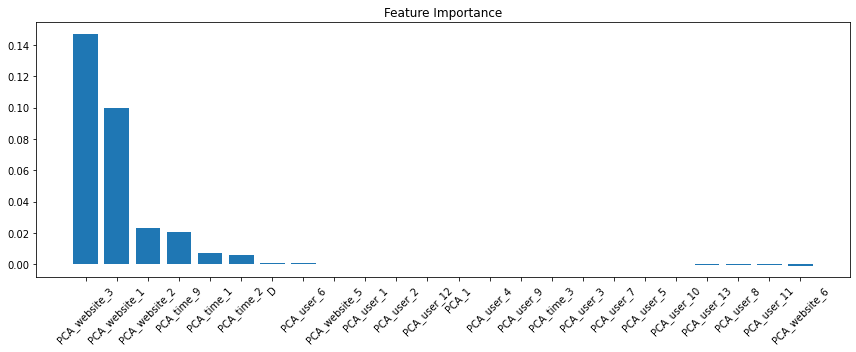

<Figure size 432x288 with 0 Axes>

In [50]:
results = permutation_importance(gnb , X_train, y_train, scoring='roc_auc')

# get importance
importances = results.importances_mean

# plot feature importance
feature_names = list(X_train)
feature_names = np.array(feature_names)

sorted_indices = np.argsort(importances)
sorted_importances =  importances[sorted_indices[::-1]]

sorted_feature_names = feature_names[sorted_indices[::-1]]

#sorted_indices = np.argsort(importances)[::-1]
fig = plt.figure(figsize = (12, 5))
plt.title('Feature Importance')
plt.bar(sorted_feature_names ,  sorted_importances , align='center')
#plt.bar(feature_names, importances, align='center')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()
plt.savefig("gnb_imp.png")

From feature importance analysis, combined with discriminative approach when building our PCA's, we can easily see that the most meaningful features in the KNN model are ones from the website and duration categories (as elaborated in the PCA section). the D feature was also somewhat important. 

### ROC-AUC Curve

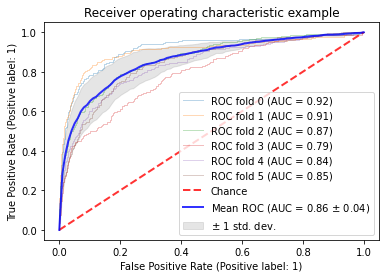

In [51]:
naive_x, naive_y, auc_naive = roc_cross_validation(gnb)

## KNN

### Evaluation Report

In [52]:
# Printing the precision and recall, among other metrics.
print_model_score_report(y_train, KNN_train_pred, KNN_train_pred_proba, y_Validation, KNN_val_pred, KNN_val_pred_proba)

train report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6640
           1       1.00      1.00      1.00      1219

    accuracy                           1.00      7859
   macro avg       1.00      1.00      1.00      7859
weighted avg       1.00      1.00      1.00      7859

train AUC score is: 1.0

validation report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92      2218
           1       0.61      0.03      0.05       402

    accuracy                           0.85      2620
   macro avg       0.73      0.51      0.48      2620
weighted avg       0.81      0.85      0.78      2620

validation AUC score is: 0.7380657577755945


As can be seen by the train report, the model is totally over-fitted. I tried to change the hyper-parameters, to avoid this situation but failed. I didn't try to change the pre-processing nor the dimensionality reduction, since the rest of the models gave good results and are not over-fitted.

### Feature Importance

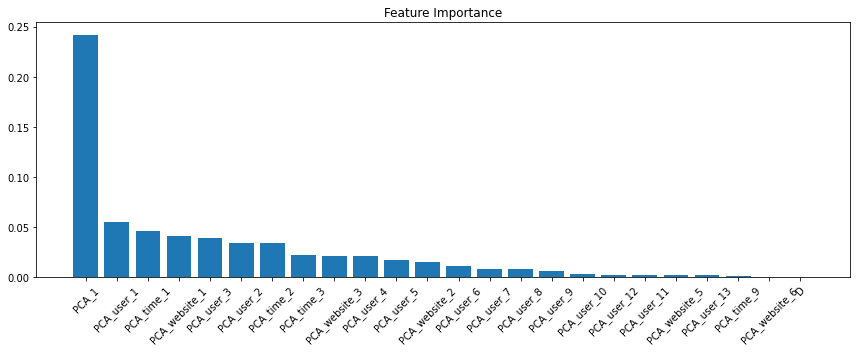

In [53]:
results = permutation_importance(knn_model , X_train, y_train, scoring='roc_auc')

#Get importance.
importances = results.importances_mean

feature_names = list(X_train)
feature_names = np.array(feature_names)

sorted_indices = np.argsort(importances)
sorted_importances =  importances[sorted_indices[::-1]]
sorted_feature_names = feature_names[sorted_indices[::-1]]

fig = plt.figure(figsize = (12, 5))
plt.title('Feature Importance')
plt.bar(sorted_feature_names ,  sorted_importances , align='center')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

From feature importance analysis, combined with discriminative approach when building our PCA's, I can easily see that the most meaningful features in the KNN model are ones from the website and duration categories(as elaborated in the PCA section). In addition, I can see that almost every feature contributed to the model, which confirms that the model is overfitted. The model used every feature to "learn", making it over-fitted.

### ROC-AUC Curve

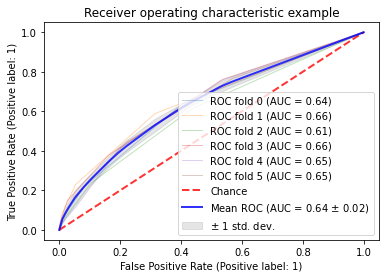

In [54]:
knn_x, knn_y, auc_knn= roc_cross_validation(KNN_model)

## Logistic regression

### Evaluation Report and Confusion Matrix

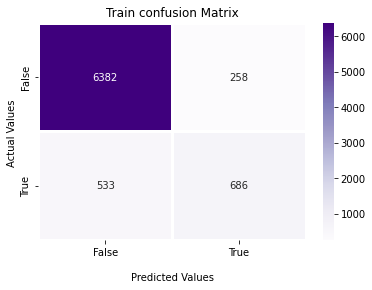

Train report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      6640
           1       0.73      0.56      0.63      1219

    accuracy                           0.90      7859
   macro avg       0.82      0.76      0.79      7859
weighted avg       0.89      0.90      0.89      7859



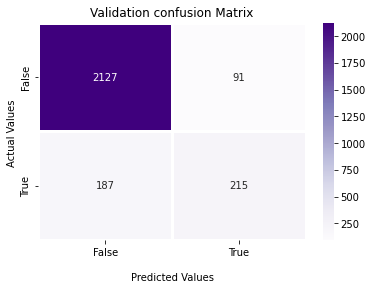

validation report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      2218
           1       0.70      0.53      0.61       402

    accuracy                           0.89      2620
   macro avg       0.81      0.75      0.77      2620
weighted avg       0.89      0.89      0.89      2620

Train AUC score is:  0.917850030145191
Validation AUC score is:  0.915621397072348


In [55]:
# Plot confusion matrix in for train prediction
cm_train = confusion_matrix(y_true=y_train, y_pred=logistic_train_pred)
ax= plt.subplot()
sns.heatmap(cm_train, annot=True, ax = ax, fmt='g',cmap='Purples',linecolor=['white'], linewidths=3); #annot=True to annotate cells
ax.set_title('Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(['False','True']) # Ticket labels - List must be in alphabetical order
ax.yaxis.set_ticklabels(['False','True'])
plt.title("Train confusion Matrix")
plt.show()
plt.cla()

# Printing the precision and recall, among other metrics
print("Train report:\n", metrics.classification_report(y_train, logistic_train_pred, ))

# Plot confusion matrix in for validation prediction
cm_validation = confusion_matrix(y_true=y_Validation, y_pred=logistic_val_pred)
ax= plt.subplot()
sns.heatmap(cm_validation, annot=True, ax = ax, fmt='g',cmap='Purples',linecolor=['white'], linewidths=3); #annot=True to annotate cells
ax.set_title('Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(['False','True']) # Ticket labels - List must be in alphabetical order
ax.yaxis.set_ticklabels(['False','True'])
plt.title("Validation confusion Matrix")
plt.show()

# Printing the precision and recall, among other metrics
print("validation report:\n", metrics.classification_report(y_Validation, logistic_val_pred))

#comparing AUC score
print("Train AUC score is: ", roc_auc_score(y_train,logistic_train_pred_proba[:, 1]))
print("Validation AUC score is: ",roc_auc_score(y_Validation,logistic_val_pred_proba[:, 1]))

Regrading differences between train and test predictions success, we can deduct from the report and the confusion matrixes, that there isn't much difference between the model prediction for validation and train data - which is good, we can assume than that our model is rightly fitted (and therefore also not over-fitted).

Also, from the report we can understand that we have a problem with the precision of buyers who actually bought products, since the score precision is only around 0.7. Also, the recall score for 1 labels is very low (both in train and validation set). From that we can understand (not surprisingly) that the data is imbalanced, since there is a big difference between the rates of "macro avg" and "weighted avg", this happens because most of our labels are 0. This is the reason for our low precision and recall score for 1 labels. Moreover, the AUC score also implies that the model are good fitted since the score between train and validation is very similar.

To improve the inclusion capability of the logistic model, I improved the preprocessing that I've done, thus by optimizing the outliers. Also, I tried to create a better fit for the dimensionality of the data, by applying mot just forward selection, but also PCA.

### Feature Importance

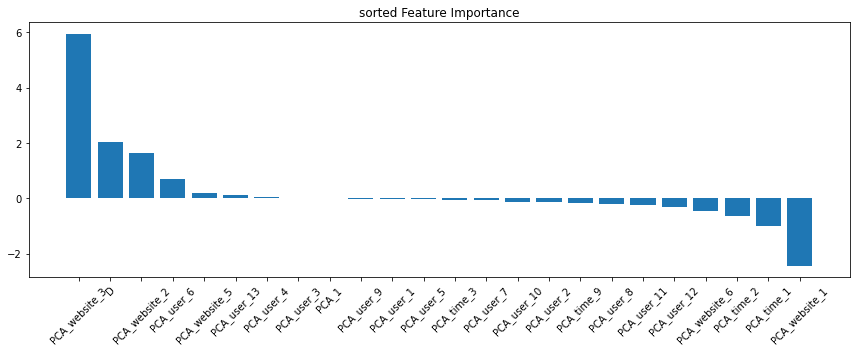

<Figure size 432x288 with 0 Axes>

In [56]:
feature_names = list(X_train)
feature_names = np.array(feature_names)

importances = logistic_model.coef_[0]

sorted_indices = np.argsort(importances)
sorted_importances =  importances[sorted_indices[::-1]]
sorted_feature_names = feature_names[sorted_indices[::-1]]

fig = plt.figure(figsize = (12, 5))
plt.title('sorted Feature Importance')
plt.bar(sorted_feature_names ,  sorted_importances , align='center')
#plt.bar(feature_names, importances, align='center')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()
plt.savefig("log_imp.png")

The logistic model use data from different classes- users detail, time and websites, but not in the unknown categories. It is interesting to see that the most significant features were user data and website on the positive coef, and timing and website features on the negative coef.

### ROC-AUC Curve

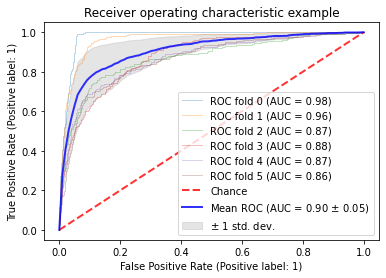

In [57]:
x_logistic, y_logistic, auc_logistic = roc_cross_validation(logistic_model)

## Ada-Boost

### Evaluation Report

In [58]:
print_model_score_report(y_train, ada_train_pred, ada_train_pred_proba, y_Validation, ada_val_pred, ada_val_pred_proba)

train report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      6640
           1       0.75      0.55      0.64      1219

    accuracy                           0.90      7859
   macro avg       0.83      0.76      0.79      7859
weighted avg       0.89      0.90      0.90      7859

train AUC score is: 0.9237245742609486

validation report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      2218
           1       0.72      0.53      0.61       402

    accuracy                           0.90      2620
   macro avg       0.82      0.75      0.78      2620
weighted avg       0.89      0.90      0.89      2620

validation AUC score is: 0.9201249164457244


Regrading differences between train and test predictions success, We can deduct from the report and the confusion matrixes, that there isn't much difference between the model prediction for validation and train data - which is good, we can assume than that our model is rightly fitted (and therefore also not over-fitted). Same as in logistic regression, since that train data is imbalanced the positive recall and precision score are low.

### Feature Importance

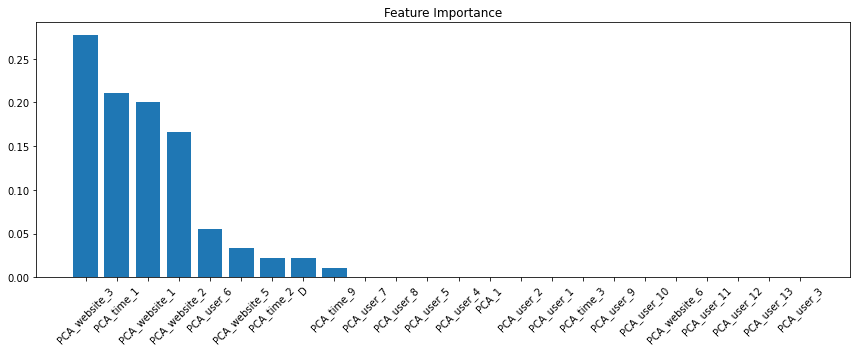

<Figure size 432x288 with 0 Axes>

In [59]:
adaboost_model = AdaBoostClassifier(**best_params_ada)
adaboost_model.fit(X_train, y_train)
importances = adaboost_model.feature_importances_


feature_importance(adaboost_model,importances, X_train, y_train)
plt.savefig("ada_imp.png")

I can see that the Adaboost first two steps use website and duration information, so I can conclude this is the most significant features class. I can see that in the last significant step, Adaboost used D feature to help him settle the last area he was struggling with (because we know that Adaboost is concentrating it's efforts in each step in those samples that his predictions were poor in the step before). I believe it's a very good step since according to our pre processing, I know that there are very few D values, but they predict the label very good. So it make since that after dealing with most of the data, Adaboost could determine the last samples using D.

### ROC-AUC Curve

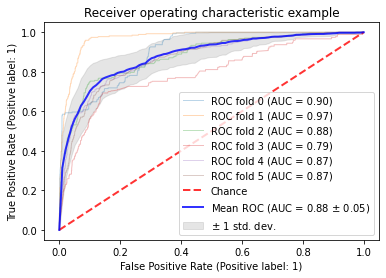

In [60]:
x_adaboost, y_adaboost, auc_adaboost = roc_cross_validation(adaboost_model)

## SVM

### Evaluation Report

In [61]:
print_model_score_report(y_train, svm_train_pred, svm_train_pred_proba, y_Validation, svm_val_pred, svm_val_pred_proba)

train report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.93      6640
           1       0.88      0.14      0.24      1219

    accuracy                           0.86      7859
   macro avg       0.87      0.57      0.58      7859
weighted avg       0.87      0.86      0.82      7859

train AUC score is: 0.9037315793115036

validation report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92      2218
           1       0.92      0.11      0.20       402

    accuracy                           0.86      2620
   macro avg       0.89      0.56      0.56      2620
weighted avg       0.87      0.86      0.81      2620

validation AUC score is: 0.9030445159235383


As can be seen, the results are very similar between the train and validation, which indicates that the model is precisely fitted. The recall score for negative prediction is too high, and because of that the score for positive predictions is very low. there's none false-negative predictions. this also affect the f1 index and gives it a low score.

### ROC-AUC Curve

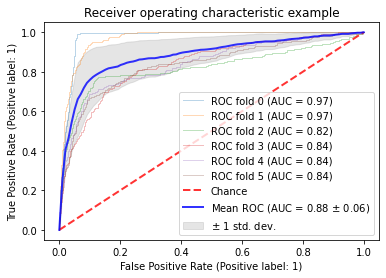

In [62]:
x_svm, y_svm, auc_svm = roc_cross_validation(svm_model)

## MLP

### Evaluation Report

In [63]:
print_model_score_report(y_train, mlp_train_pred, mlp_train_pred_proba, y_Validation, mlp_val_pred, mlp_val_pred_proba)

train report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      6640
           1       0.75      0.66      0.70      1219

    accuracy                           0.91      7859
   macro avg       0.84      0.81      0.82      7859
weighted avg       0.91      0.91      0.91      7859

train AUC score is: 0.9407574102809928

validation report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      2218
           1       0.70      0.62      0.66       402

    accuracy                           0.90      2620
   macro avg       0.82      0.79      0.80      2620
weighted avg       0.90      0.90      0.90      2620

validation AUC score is: 0.9239454216743156


As can be seen, the results are very similar between the train and validation, which indicates that the model is precisely fitted. all of the indexes has a relatively good score compared to other models. This is one of the best models I succeeded in creating.

### ROC-AUC Curve

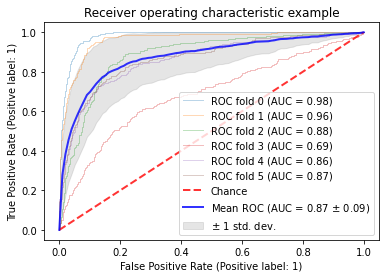

In [64]:
mlp_x, mlp_y, auc_mlp= roc_cross_validation(mlp_model)

## Ensemble

### Evaluation Report

In [65]:
print_model_score_report(y_train, ensemble_train_pred, ensemble_train_pred_proba, y_Validation, ensemble_val_pred, ensemble_val_pred_proba)

train report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      6640
           1       0.69      0.62      0.65      1219

    accuracy                           0.90      7859
   macro avg       0.81      0.78      0.79      7859
weighted avg       0.89      0.90      0.89      7859

train AUC score is: 0.9132763622167093

validation report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      2218
           1       0.68      0.61      0.64       402

    accuracy                           0.90      2620
   macro avg       0.81      0.78      0.79      2620
weighted avg       0.89      0.90      0.89      2620

validation AUC score is: 0.911498638457846


As can be seen, the results are very similar between the train and validation, which indicates that the model is precisely fitted. all of the indexes has a relatively good score compared to other models. This us one of the best models I succeeded in creating.

The ensemble got rates that are similar to the rates of logistic regression, because of that I can understand that the logistic regression is the most affective model in the ensemble. Also, since the ensemble is not significantly better than the log regression I figured out that the rest of the models are not making predictions that are helping the ensemble to learn the data in a better way.

### ROC-AUC Curve

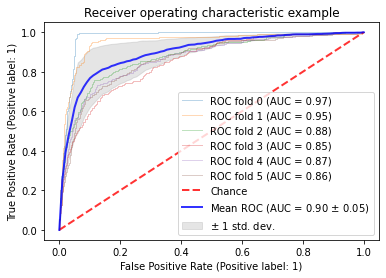

In [66]:
x_ensemble, y_ensemble, auc_ensemble = roc_cross_validation(clf)

## ROC-AUC of all Models in one plot

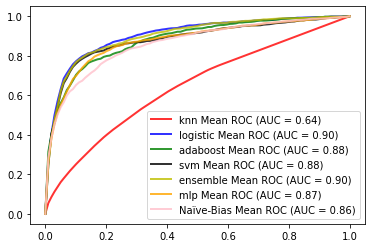

In [67]:
X = [knn_x, x_logistic,x_adaboost, x_svm, x_ensemble, mlp_x, naive_x]
Y = [knn_y, y_logistic, y_adaboost,y_svm, y_ensemble, mlp_y, naive_y]
AUC = [auc_knn, auc_logistic, auc_adaboost, auc_svm, auc_ensemble, auc_mlp, auc_naive]
color = ["r", "b", "g", "black", 'y', 'orange', 'pink']
name = ["knn", "logistic", "adaboost", "svm", "ensemble", "mlp", "Naïve-Bias"]
for i in range(len(X)):
    plt.plot(
        X[i],
        Y[i],
        color = color[i],
        label=r"{} Mean ROC (AUC = %0.2f)".format(name[i]) % (AUC[i]),
        lw=2,
        alpha=0.8,
    )
plt.legend()
plt.show()

# Test Labels Prediction

The ensemble model got the best ROC curve, so I decided to use it to predict the test labels.

In [68]:
estimators = [("naive base", gnb), ("lgt", logistic_model), ("adaboost", adaboost_model),("svm", svm_model)]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train)
test_pred = clf.predict(x_test)
test_pred_proba = clf.predict_proba(x_test)
prediction = pd.DataFrame(test_pred_proba[:,1], columns=['predict_prob']).to_csv('Submission_group_43.csv')

# Pipe-Line

In [69]:
#### Imports ####
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from copy import deepcopy
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn import svm
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

#### Load data ####
test_data = pd.read_csv('test.csv')
train_data = pd.read_csv('train.csv')
labels = train_data["purchase"]

#####  Utility functions #####
#input: <np.arr> feature, <np.arr> lables, <list> values_range: a range of optional outcasts boundries
#output: <int> best_boundry - the best boundry, <int> max_corr - the maximum correaltaion hat the boundry resulted with. 
def find_best_outcast_boundry(feature, labels, values_range):
    max_corr = 0
    best_boundry = 0
    
    for i in values_range:
        temp_corr = feature[feature < i].corr(labels)
        if(temp_corr > max_corr):
            max_corr = temp_corr
            best_boundry = i
    
    return(best_boundry, max_corr)

#input: <df> data, <np.arr> feature,  <str> feature_name: a feature name
#output: The given feature is splitted into different cloumn according to each unique value (using onehotencoding).
def ohe_encoding(data, feature, feature_name):
    count_distinc_values = len(feature.unique()) + 1 #+1 is beacuse im going to use it for range
    onehotencoder = OneHotEncoder()
    #Reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object .
    X = onehotencoder.fit_transform(feature.values.reshape(-1,1)).toarray()

    #To add this back into the original dataframe 
    dfOneHot = pd.DataFrame(X, columns = [feature_name +"_" + str(int(i)) for i in range(1,count_distinc_values)]) 
    data = pd.concat([data, dfOneHot], axis=1)
    return data

#input: <np.arr> feature: a feature
#output: Returns the edited feature after removing outliers accrding to IQR algorithm (and according to cappin or replacing with nan method).
def remove_outlier_IQR(feature,treament = 'cap', factor=1.5):
    Q1=feature.quantile(0.25)
    Q3=feature.quantile(0.75)
    IQR=Q3-Q1
    floor = Q1- (factor *IQR)
    ceil = Q3 + (factor * IQR)
    if treament == 'remove':
        count_old_nan = feature.isna().sum()
        feature[(feature <= floor) | (feature >= ceil)] = np.NaN

    elif treament == 'cap':
        count =(feature[(feature <= floor) | (feature >= ceil)]).shape[0]
        feature = feature.clip(floor, ceil)

    return feature

#input: <np.arr> feature: a feature, <str> feature_name: a feature name
#output: <np.arr> Feature after log transformation, also prints the skew before and after log transformation.
def log_transformation_affection_on_skew(feature):
    
    feature = feature.map(lambda i: np.log(i) if i > 0 else i) 
    return feature


#input: <pd.df> x: features, <np.arr> y: lables: a feature name, <int> np: how much feature to select:
#output: <pd.d> returns masking of features that should stay in the data

def forward_selection(x, y, np):
  sfs = SequentialFeatureSelector(LinearRegression(),
          n_features_to_select=np,
          direction = 'forward',
          cv= 3,
          scoring = 'roc_auc')

  sfs.fit(x, y)
  sfs.n_features_to_select_
  masking_for_features = sfs.get_support()
  return masking_for_features
     

#input: <skleran.model> model
#output: <void> plot k fold cross validation roc auc curve
def roc_cross_validation(model):
    cv = StratifiedKFold(n_splits=6)
    classifier =model
    i=0
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for train_index, test_index in cv.split(og_x, og_y):
        
        X_train, X_test = (og_x.T[train_index]).T, (og_x.T[test_index]).T
        y_train, y_test = og_y[train_index], og_y[test_index]
        classifier.fit(X_train, y_train)
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_test,
            y_test,
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        i=i+1
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")
    plt.show()
    return mean_fpr, mean_tpr, mean_auc


def pca_dim_reduction(X, x_test, p):
    """
    Returns arrays of principal components explaining (100*p)% of the variance, one for train and one for test.
    X: 2d numpy array of data I want to apply PCA on. 
    p: float in the range (0,1]. The proportion of variance explained by components
    """
    X = normalize_mean(X)
    
    pca = PCA(n_components=(p), svd_solver='full')
    pca.fit(X)
    X_pca = pca.transform(X)
    x_test_pca = pca.transform(x_test)
    return X_pca, x_test_pca

#input: <pd.df> data
#output: <pd.df> data and plot k fold cross validation roc auc curve
#Remove means before pca.
def normalize_mean(data):
  data = data - data.mean()
  return data

##### Preprossecing ######

#Num of admin preprossecing#
num_of_admin_pages = train_data["num_of_admin_pages"]
train_data["num_of_admin_pages"] = num_of_admin_pages.add(1)
num_of_admin_pages = train_data["num_of_admin_pages"]
train_data["num_of_admin_pages"] = log_transformation_affection_on_skew(num_of_admin_pages)
num_of_admin_pages = train_data["num_of_admin_pages"]
num_of_admin_pages.fillna(num_of_admin_pages.mean(), inplace=True)
num_of_admin_test = test_data["num_of_admin_pages"]
test_data["num_of_admin_pages"] = num_of_admin_test.add(1)
num_of_admin_test = test_data["num_of_admin_pages"]
test_data["num_of_admin_pages"] = log_transformation_affection_on_skew(num_of_admin_test)
num_of_admin_test = test_data["num_of_admin_pages"]
num_of_admin_test.fillna(num_of_admin_test.mean(), inplace = True)

#Num of info preprossecing#
num_of_info_pages = train_data["num_of_info_pages"]
num_of_info_pages.replace("minutes", 0)
info_num_boundry, max_corr_info_num = find_best_outcast_boundry(num_of_info_pages, labels, [0, 1, 2, 3,4,5,6,7,8,9])
num_of_info_pages[num_of_info_pages > info_num_boundry] = None #remove outcasts
num_of_info_pages.fillna(num_of_info_pages.mean(), inplace=True)
num_of_info_test = test_data["num_of_info_pages"]
num_of_info_test.replace("minutes", 0)
num_of_info_test[num_of_info_test> info_num_boundry]= None
num_of_info_test.fillna(num_of_info_test.mean(), inplace=True)

#Num of product preprossecing#
num_of_product_pages = train_data["num_of_product_pages"]
train_data["num_of_product_pages"] = log_transformation_affection_on_skew(num_of_product_pages)
num_of_product_pages_mean, num_of_product_pages_std = num_of_product_pages.mean(), num_of_product_pages.std()
cut_off = num_of_product_pages_std * 3
lower, upper = num_of_product_pages_mean - cut_off, num_of_product_pages_mean + cut_off
num_of_product_pages[num_of_product_pages > upper] = None
num_of_product_pages[num_of_product_pages < lower] = None
num_of_product_pages.fillna(num_of_product_pages_mean, inplace=True)
num_of_product_test = test_data["num_of_product_pages"]
test_data["num_of_product_pages"] = log_transformation_affection_on_skew(num_of_product_test)
num_of_product_test.fillna(num_of_product_test.mean(), inplace=True)
num_of_product_test_mean, num_of_product_test_std = num_of_product_test.mean(), num_of_product_test.std()
cut_off = num_of_product_test_std * 3
lower, upper = num_of_product_test_mean - cut_off, num_of_product_test_mean + cut_off
num_of_product_test[num_of_product_test > upper] = None
num_of_product_test[num_of_product_test < lower] = None
num_of_product_test.fillna(num_of_product_test_mean, inplace=True)

#Admin duration preprossecing#
admin_page_duration = train_data["admin_page_duration"]
log_transformation_affection_on_skew(deepcopy(num_of_admin_pages))
train_data["num_of_admin_pages"]  = remove_outlier_IQR(num_of_admin_pages)
admin_page_duration.fillna(admin_page_duration.mean(), inplace=True)
admin_page_duration_test = test_data["admin_page_duration"]
test_data["admin_page_duration"]  = remove_outlier_IQR(admin_page_duration_test)
admin_page_duration_test.fillna(admin_page_duration_test.mean(), inplace=True)

#Info duration preprossecing#
train_data["info_page_duration"]= train_data["info_page_duration"].str.replace('minutes', '')
train_data["info_page_duration"] = train_data["info_page_duration"].astype(float)
info_duration = train_data["info_page_duration"]
train_data["info_page_duration"] = info_duration.add(1)
info_duration = train_data["info_page_duration"]
train_data["info_page_duration"] = log_transformation_affection_on_skew(info_duration)
info_duration = train_data["info_page_duration"]
mean = info_duration[info_duration > 0].mean()
info_duration.fillna(mean, inplace=True)
test_data["info_page_duration"]= test_data["info_page_duration"].str.replace('minutes', '')
test_data["info_page_duration"] = test_data["info_page_duration"].astype(float)
info_duration_test = test_data["info_page_duration"]
test_data["info_page_duration"] = info_duration_test.add(1)
info_duration_test = test_data["info_page_duration"]
test_data["info_page_duration"] = log_transformation_affection_on_skew(info_duration_test)
info_duration_test = test_data["info_page_duration"]
mean_test = info_duration_test[info_duration_test > 0].mean()
info_duration_test.fillna(mean_test.mean(), inplace=True)

#Product duration preprossecing#
train_data["product_page_duration"]= train_data["product_page_duration"].str.replace('minutes', '')
train_data["product_page_duration"] = train_data["product_page_duration"].astype(float)
test_data["product_page_duration"]= test_data["product_page_duration"].str.replace('minutes', '')
test_data["product_page_duration"] = test_data["product_page_duration"].astype(float)
product_duration = train_data["product_page_duration"]
product_duration_test = test_data["product_page_duration"]
product_duration[product_duration >product_duration.quantile(.95)] = None
product_duration_test[product_duration_test >product_duration_test.quantile(.95)]= None
product_duration.fillna(product_duration.mean(), inplace=True)
product_duration_test.fillna(product_duration_test.mean(), inplace=True)

#bounce rate preprossecing#
BounceRates = train_data["BounceRates"]
train_data["BounceRates"] = BounceRates.add(1)
BounceRates = train_data["BounceRates"]
train_data["BounceRates"] = log_transformation_affection_on_skew(BounceRates)
BounceRates = train_data["BounceRates"]
train_data["BounceRates"] = remove_outlier_IQR(BounceRates)
BounceRates = train_data["BounceRates"]
BounceRates.fillna(BounceRates.median(), inplace=True)
BounceRates_test = test_data["BounceRates"]
test_data["BounceRates"] = BounceRates_test.add(1)
BounceRates_test = test_data["BounceRates"]
test_data["BounceRates"] = log_transformation_affection_on_skew(BounceRates_test)
test_data["BounceRates"] = remove_outlier_IQR(BounceRates_test)
BounceRates_test = test_data["BounceRates"]
test_data.fillna(BounceRates_test.median(), inplace=True)

#EXIT rate preprossecing#
ExitRates = train_data["ExitRates"]
train_data["ExitRates"] = log_transformation_affection_on_skew(deepcopy(ExitRates))
ExitRates = train_data["ExitRates"]
ExitRates_mean, ExitRates_std = ExitRates.mean(), ExitRates.std()
cut_off = ExitRates_std * 3
lower, upper = ExitRates_mean - cut_off, ExitRates_mean + cut_off
ExitRates[ExitRates > upper] = None
ExitRates[ExitRates < lower] = None
ExitRates.fillna(ExitRates_mean, inplace=True)
ExitRates_tests = test_data["ExitRates"]
test_data["ExitRates"] = log_transformation_affection_on_skew(deepcopy(ExitRates_tests))
ExitRates_tests = test_data["ExitRates"]
ExitRates_mean, ExitRates_std = ExitRates_tests.mean(), ExitRates_tests.std()
cut_off = ExitRates_std * 3
lower, upper = ExitRates_mean - cut_off, ExitRates_mean + cut_off
ExitRates_tests[ExitRates_tests > upper] = None
ExitRates_tests[ExitRates_tests < lower] = None
ExitRates_tests.fillna(ExitRates_mean, inplace=True)

#page values rate preprossecing#
PageValues = train_data["PageValues"]
train_data["PageValues"] = PageValues.add(1)
PageValues = train_data["PageValues"]
train_data["PageValues"] = log_transformation_affection_on_skew(PageValues)
PageValues = train_data["PageValues"]
PageValues.fillna(PageValues.median(), inplace=True)
PageValuestest = test_data["PageValues"]
test_data["PageValues"] = PageValuestest.add(1)
PageValues_test = test_data["PageValues"]
test_data["PageValues"] = log_transformation_affection_on_skew(PageValues_test)
PageValues_test.fillna(PageValues_test.median(), inplace=True)

#device preprossecing#
device = train_data["device"]
device.fillna(device.mode(), inplace=True)
train_data = ohe_encoding(train_data, device, "device")
device_test = test_data["device"]
test_data = ohe_encoding(test_data, device_test, "device")
device_test.fillna(device_test.mode(), inplace=True)

#internet browser preprossecing#
train_data["internet_browser"] = train_data["internet_browser"].str.split('_').str[:-1].str.join('_')
train_data["internet_browser"] = train_data["internet_browser"].str.replace("_", "")
train_data["internet_browser"] = train_data["internet_browser"].str.replace('\d+', '')
internet_browser = train_data["internet_browser"]
internet_browser[internet_browser == 'safari'] = 1
internet_browser[internet_browser == 'browser'] = 2
internet_browser[internet_browser == 'chrome'] = 3
internet_browser[internet_browser == 'edge'] = 4
internet_browser.fillna(internet_browser.mode()[0], inplace=True)
train_data = ohe_encoding(train_data, internet_browser, "internet_browser")
test_data["internet_browser"] = test_data["internet_browser"].str.split('_').str[:-1].str.join('_')
test_data["internet_browser"] = test_data["internet_browser"].str.replace("_", "")
test_data["internet_browser"] = test_data["internet_browser"].str.replace('\d+', '')
internet_browser_test = test_data["internet_browser"]
internet_browser_test[internet_browser_test == 'safari'] = 1
internet_browser_test[internet_browser_test == 'browser'] = 2
internet_browser_test[internet_browser_test == 'chrome'] = 3
internet_browser_test[internet_browser_test == 'edge'] = 4
internet_browser_test.fillna(internet_browser_test.mode()[0], inplace=True)
test_data = ohe_encoding(test_data, internet_browser_test, "internet_browser")

#region preprossecing#
Region = train_data["Region"]
Region.fillna(Region.mode()[0], inplace=True)
train_data = ohe_encoding(train_data, Region, "Region")
Region_test = test_data["Region"]
Region_test.fillna(Region_test.mode()[0], inplace=True)
test_data = ohe_encoding(test_data, Region_test, "Region")

#user type preprossecing#
user_type = train_data["user_type"]
user_type[user_type == 'New_Visitor'] = 0
user_type[user_type == 'Returning_Visitor'] = 1
user_type[user_type == 'Other'] = np.NaN
user_type.fillna(user_type.mode()[0], inplace=True)
user_type_test = test_data["user_type"]
user_type_test[user_type_test == 'New_Visitor'] = 0
user_type_test[user_type_test == 'Returning_Visitor'] = 1
user_type_test[user_type_test == 'Other'] = np.NaN
user_type_test.fillna(user_type_test.mode()[0], inplace=True)

#month preprossecing#
Month = train_data["Month"]
con_dict ={month: index for index, month in enumerate(calendar.month_abbr) if month}
Month.replace("June","Jun", inplace=True)
Month.replace(con_dict, inplace=True)
Month.fillna(int(Month.mode()), inplace=True)
Month = Month.astype(int)
train_data = ohe_encoding(train_data, Month, "Month")
Month_test = test_data["Month"]
Month_test.replace("June","Jun", inplace=True)
Month_test.replace(con_dict, inplace=True)
Month_test.fillna(int(Month_test.mode()), inplace=True)
Month_test = Month_test.astype(int)
test_data = ohe_encoding(test_data, Month_test, "Month")

#Weekend preprossecing#
Weekend  = train_data["Weekend"]
Weekend.replace({True:1, False:0}, inplace=True)
Weekend.fillna(Weekend.mode()[0], inplace=True)
Weekend_test  = test_data["Weekend"]
Weekend_test.replace({True:1, False:0}, inplace=True)
Weekend_test.fillna(Weekend_test.mode()[0], inplace=True)

#holiday preprossecing#
closeness_to_holiday =  train_data["closeness_to_holiday"]
closeness_to_holiday.fillna(closeness_to_holiday.mode()[0], inplace=True)
closeness_to_holiday_test =  test_data["closeness_to_holiday"]
closeness_to_holiday_test.fillna(closeness_to_holiday_test.mode()[0], inplace=True)

#A preprossecing#
train_data["A"] = train_data["A"].str.replace("c_", "")
train_data["A"] = train_data["A"].str.replace("_", ".")
train_data["A"] = train_data["A"].astype(float)
A = train_data["A"]
A[A>20] = 20
A.fillna(A.mode()[0], inplace=True)
train_data = ohe_encoding(train_data, A, "A")
test_data["A"] = test_data["A"].str.replace("c_", "")
test_data["A"] = test_data["A"].str.replace("_", ".")
test_data["A"] = test_data["A"].astype(float)
A_test = test_data["A"]
A_test[(A_test>20) & (21>A_test)] = 20
A_test.fillna(A_test.mode()[0], inplace=True)
test_data = ohe_encoding(test_data, A_test, "A")

#B preprossecing#
B = train_data["B"]
B_mean, B_std = B.mean(), B.std()
cut_off = B_std * 3
lower, upper = B_mean - cut_off, B_mean + cut_off
B[B>upper] =None
B[B<lower] = None
B.fillna(B_mean, inplace=True)
B_test = test_data["B"]
B_test_mean, B_test_std = B_test.mean(), B_test.std()
cut_off_test = B_test_std * 3
lower_test, upper_test = B_test_mean - cut_off_test, B_test_mean + cut_off_test
B_test[B_test>upper_test] =None
B_test[B_test<lower_test] = None
B_test.fillna(B_test_mean, inplace=True)

#C preprossecing#
train_data['C'] = train_data['C'].str.replace('log', '')
train_data['C'] = train_data['C'].str.replace('_', '')
train_data['C'] = train_data['C'].astype(float)
C = train_data['C']
C_high = C[C>7000]
C_low =C[C<1000]
C.fillna(int(C_low.mode()), inplace=True)
test_data['C'] = test_data['C'].str.replace('log', '')
test_data['C'] = test_data['C'].str.replace('_', '')
test_data['C'] = test_data['C'].astype(float)
C_test = test_data['C']
C_low_test = C_test[C_test<1000]
C_test.fillna(int(C_low_test.mode()), inplace=True)

#D preprossecing#
D = train_data["D"]
D_test = test_data["D"]
D_NO =D[labels==0]
D_YES =D[labels==1]
q3_Y = D_YES.quantile(0.75)
q1_N = D_NO.quantile(0.25)
med_val =D[(q3_Y<D)&(D<q1_N)].mean()
D.fillna(0, inplace=True)
train_data.loc[((train_data["D"]< med_val) & (train_data["D"]!=0)), "D"] = 1
train_data.loc[train_data["D"]> med_val, "D"] = -1
D_NO_test =D_test[labels==0]
D_YES_test =D_test[labels==1]
q3_Y_test = D_YES_test.quantile(0.75)
q1_N_test = D_NO_test.quantile(0.25)
med_val_test =D_test[(q3_Y_test<D_test)&(D_test<q1_N_test)].mean()
D_test.fillna(0, inplace=True)
test_data.loc[((test_data["D"]< med_val_test) & (test_data["D"]!=0)), "D"] = 1
test_data.loc[test_data["D"]> med_val_test, "D"] = -1

######Normalization Dimension reduction and spliting to validation#####
train_data = train_data.drop(['id', 'Month', 'Region', 'device', 'internet_browser'], 1)
test_data = test_data.drop(['id', 'Month', 'Region', 'device', 'internet_browser'], 1)

numeric_features = ["num_of_admin_pages", "admin_page_duration", "num_of_info_pages", "info_page_duration",
"num_of_product_pages", "product_page_duration", "A", "C", "BounceRates", "ExitRates", "PageValues"]
for feature in numeric_features:
    feature_scaled = (train_data[feature] - train_data[feature].min())/ (train_data[feature].max() - train_data[feature].min())
    train_data[feature] = feature_scaled
numeric_data_test = ["num_of_admin_pages", "admin_page_duration", "num_of_info_pages", "info_page_duration",
"num_of_product_pages", "product_page_duration", "A", "C", "BounceRates", "ExitRates","PageValues"]
for feature in numeric_features:
    feature_scaled = (test_data[feature] - test_data[feature].min())/ (test_data[feature].max() - test_data[feature].min())
    test_data[feature] = feature_scaled

#drop columns
y_train = train_data['purchase']
x_train = train_data.drop('purchase',1)
x_train = x_train.drop("total_duration",1)
x_test = test_data.drop("total_duration",1)
columns = x_train.columns

x_train = x_train.drop(['admin_page_duration','info_page_duration', 'product_page_duration'], 1)
x_test = x_test.drop(['admin_page_duration','info_page_duration', 'product_page_duration'], 1)

##### PCA ####
website_data = x_train[['num_of_admin_pages', 'num_of_info_pages', 'num_of_product_pages',
       'BounceRates', 'ExitRates', 'PageValues']]
timing_of_visit_data = x_train[['closeness_to_holiday','Weekend', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10']]
user_details = x_train[['device_1', 'device_2',
       'device_3', 'device_4', 'internet_browser_1', 'internet_browser_2',
       'internet_browser_3', 'internet_browser_4','Region_1', 'Region_2',
        'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8',
       'Region_9', 'user_type']]
unknown_variabalse_data = x_train[['A', 'B', 'C']]
D_collumn = x_train['D']
website_data_test = x_test[['num_of_admin_pages', 'num_of_info_pages', 'num_of_product_pages',
       'BounceRates', 'ExitRates', 'PageValues']]
timing_of_visit_data_test = x_test[['closeness_to_holiday','Weekend', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10']]
user_details_test = x_test[['device_1', 'device_2',
       'device_3', 'device_4', 'internet_browser_1', 'internet_browser_2',
       'internet_browser_3', 'internet_browser_4','Region_1', 'Region_2',
        'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8',
       'Region_9', 'user_type']]
unknown_variabalse_data_test = x_test[['A', 'B', 'C']]
D_collumn_test = x_test['D']
p =0.98
website_pca, website_test_pca = pca_dim_reduction(website_data, website_data_test, p)
timing_of_visit_pca, timing_of_visit_test_pca = pca_dim_reduction(timing_of_visit_data, timing_of_visit_data_test, 0.96)
user_details_pca, user_details_test_pca = pca_dim_reduction(user_details, user_details_test, 0.96)
unknown_variabalse_pca, unknown_variabalse_test_pca = pca_dim_reduction(unknown_variabalse_data, unknown_variabalse_data_test, p)
website_pca_data = pd.DataFrame(website_pca, columns = ['PCA_website_1', 'PCA_website_2', 'PCA_website_3', 'PCA_website_4', 'PCA_website_5', 'PCA_website_6'])
timing_pca_data = pd.DataFrame(timing_of_visit_pca, columns = ['PCA_time_1','PCA_time_2', 'PCA_time_3', 'PCA_time_4',
'PCA_time_5', 'PCA_time_6', 'PCA_time_7', 'PCA_time_8', 'PCA_time_9'])
user_pca_data = pd.DataFrame(user_details_pca, columns = ['PCA_user_1','PCA_user_2', 'PCA_user_3', 'PCA_user_4',
'PCA_user_5','PCA_user_6','PCA_user_7','PCA_user_8', 'PCA_user_9', 'PCA_user_10','PCA_user_11','PCA_user_12','PCA_user_13'])
unknown_variabalse_pca_data = pd.DataFrame(unknown_variabalse_pca, columns = ['PCA_1'])
new_train_data = pd.concat([website_pca_data,timing_pca_data, user_pca_data, unknown_variabalse_pca_data, D_collumn], axis=1)
website_pca_data_test = pd.DataFrame(website_test_pca, columns = ['PCA_website_1', 'PCA_website_2', 'PCA_website_3', 'PCA_website_4', 'PCA_website_5', 'PCA_website_6'])
timing_pca_data_test = pd.DataFrame(timing_of_visit_test_pca, columns = ['PCA_time_1','PCA_time_2', 'PCA_time_3', 'PCA_time_4',
'PCA_time_5', 'PCA_time_6', 'PCA_time_7', 'PCA_time_8', 'PCA_time_9'])
user_pca_data_test = pd.DataFrame(user_details_test_pca, columns = ['PCA_user_1','PCA_user_2', 'PCA_user_3', 'PCA_user_4',
'PCA_user_5','PCA_user_6','PCA_user_7','PCA_user_8', 'PCA_user_9', 'PCA_user_10','PCA_user_11','PCA_user_12','PCA_user_13'])
unknown_variabalse_pca_data_test = pd.DataFrame(unknown_variabalse_test_pca, columns = ['PCA_1'])
new_test_data = pd.concat([website_pca_data_test,timing_pca_data_test, user_pca_data_test, unknown_variabalse_pca_data_test, D_collumn_test], axis=1)

#### forward selection ###
sub_set = forward_selection(new_train_data, y_train, 0.8)
sub_data = new_train_data.T[sub_set]
sub_data_test = new_test_data.T[sub_set]#using the suset the train chose
x_test =sub_data_test.T

#### spliting to validation ####
og_y = y_train.copy()
og_x = sub_data.T.copy()
X_train, X_Validation, y_train, y_Validation = train_test_split(sub_data.T, y_train, test_size=0.25,random_state = 42,shuffle = True)

## naive bias ####
gnb = GaussianNB()
gnb.fit(X_train, y_train)


#### log regression #####
pipe = LogisticRegression()
param_grid = {
'penalty' : ['l1', 'l2'],
'C' : np.logspace(-4, 4, 7),
'solver' : ['liblinear'],
'max_iter' : [100, 1500],
'fit_intercept': [True, False]
}
clf = GridSearchCV(pipe, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1, scoring='roc_auc')
# Fit on data.
best_clf = clf.fit(X_train, y_train)
best_params_log = clf.best_params_
logistic_model = LogisticRegression(**best_params_log)
logistic_model.fit(X_train, y_train)
best_score = clf.best_score_

### ada boost ####
grid = dict()
grid['n_estimators'] = [80,90,95]
grid['learning_rate'] = [0.11,0.12, 0.13]
adaboost_model = AdaBoostClassifier()
ADA_Grid = GridSearchCV(estimator = adaboost_model, param_grid= grid , scoring = 'roc_auc',  cv = 3, verbose=2, n_jobs = 4)
ADA_Grid.fit(X_train, y_train)
best_params_ada = ADA_Grid.best_params_
best_score =ADA_Grid.best_score_

#### svm #####
param_grid = {'C': [400],'gamma':[0.00001],'kernel': ['rbf']}
grid = GridSearchCV(SVC(probability=True), param_grid, refit = True, scoring = 'roc_auc', verbose = 3)
grid.fit(X_train, y_train)
best_params_svm = grid.best_params_
svm_model = svm.SVC(**best_params_svm)


#### ensemble #####
estimators = [("naive base", gnb), ("lgt", logistic_model), ("adaboost", adaboost_model),("svm", svm_model)]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train)


### test lable predictions ####
estimators = [("naive base", gnb), ("lgt", logistic_model), ("adaboost", adaboost_model),("svm", svm_model)]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train, y_train)
test_pred = clf.predict(x_test)
test_pred_proba = clf.predict_proba(x_test)
prediction = pd.DataFrame(test_pred_proba[:,1], columns=['predict_prob']).to_csv('Submission_group_43.csv')

Fitting 3 folds for each of 56 candidates, totalling 168 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ....C=400, gamma=1e-05, kernel=rbf;, score=0.884 total time=   7.6s
[CV 2/5] END ....C=400, gamma=1e-05, kernel=rbf;, score=0.905 total time=   7.4s
[CV 3/5] END ....C=400, gamma=1e-05, kernel=rbf;, score=0.906 total time=   7.7s
[CV 4/5] END ....C=400, gamma=1e-05, kernel=rbf;, score=0.909 total time=   7.9s
[CV 5/5] END ....C=400, gamma=1e-05, kernel=rbf;, score=0.907 total time=   7.7s


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0f72010b-8f8c-4b2a-8f09-bb5c1324da76' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>